# Сборный Проект — 2. HR-аналитика

**Описание проекта**

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Задача 1: предсказание уровня удовлетворённости сотрудника (задача регрессии)**

Для этой задачи заказчик предоставил данные с признаками:
* id — уникальный идентификатор сотрудника;
* dept — отдел, в котором работает сотрудник;
* level — уровень занимаемой должности;
* workload — уровень загруженности сотрудника;
* employment_years — длительность работы в компании (в годах);
* last_year_promo — показывает, было ли повышение за последний год;
* last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
* supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
* salary — ежемесячная зарплата сотрудника;
* job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

Тренировочная выборка:
* train_job_satisfaction_rate.csv

Входные признаки тестовой выборки:
* test_features.csv

Целевой признак тестовой выборки:
* test_target_job_satisfaction_rate.csv

Выберите лучшую модель и проверьте её качество. Выбор делайте на основе новой метрики — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). 

Метрика SMAPE вычисляется так:

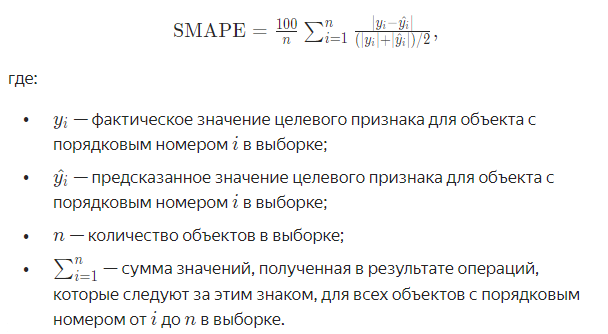

Критерий успеха: SMAPE ≤ 15 на тестовой выборке.

**Задача 2: предсказание увольнения сотрудника из компании (задача классификации)**

Для этой задачи вы можете использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.

Тренировочная выборка:
* train_quit.csv

Входные признаки тестовой выборки те же, что и в прошлой задаче:
* test_features.csv

Целевой признак тестовой выборки:
* test_target_quit.csv

Метрика оценки качества в этой задаче — ROC-AUC. Критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке. 

**Для обеих задач заполнение пропусков и подготовка данных выпляется в пайплайне предобработки!**

**Библиотеки и константы для решения задач**

In [1]:
!pip install --upgrade scikit-learn -q

In [2]:
!pip install phik -q
!pip install shap -q
!pip install imblearn -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import shap
import phik
import sklearn

#from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC 

from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix

import warnings

warnings.filterwarnings("ignore")
mpl.style.use(['bmh'])


In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Задача: предсказание уровня удовлетворённости сотрудника

### Загрузка данных

In [4]:
try:
    df = pd.read_csv('train_job_satisfaction_rate.csv')
except:
    df = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')

try:
    X_test_1 = pd.read_csv('test_features.csv')
except:
    X_test_1 = pd.read_csv('/datasets/test_features.csv')
    
try:
    y_test_1 = pd.read_csv('test_target_job_satisfaction_rate.csv')
except:
    y_test_1 = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [5]:
df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Датафрейм df содержит 4000 строк и 10 столбцов, включая целевую переменную.  Обнаружены пропуски в столбцах dept (6 значений) и level (4 значения). Типы данных соответствуют ожидаемым.

In [7]:
df.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


Аномальные значения в датафрейме df не выявлены. Все числовые признаки находятся в пределах ожидаемого диапазона.

In [8]:
df.describe(include='object')

,dept,level,workload,last_year_promo,last_year_violations
count,3994,3996,4000,4000,4000
unique,5,3,3,2,2
top,sales,junior,medium,no,no
freq,1512,1894,2066,3880,3441


На данный момент данные выглядят корректно. Более подробный анализ уникальных значений будет выполнен в процессе предобработки.

In [9]:
X_test_1.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [10]:
X_test_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Датафрейм df содержит 2000 строк и 9 столбцов, без целевого признака.  Обнаружены пропуски в столбцах dept (2 значения) и level (1 значение). Типы данных соответствуют ожидаемым.

In [11]:
X_test_1.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


Аномальные значения в датафрейме df не выявлены. Все числовые признаки находятся в пределах ожидаемого диапазона.

In [12]:
X_test_1.describe(include='object')

,dept,level,workload,last_year_promo,last_year_violations
count,1998,1999,2000,2000,2000
unique,6,3,4,2,2
top,sales,junior,medium,no,no
freq,763,974,1043,1937,1738


Модальные значения в X_test_1 совпадают с модальным значениями в исходном датафрейме df. Однако наблюдаются различия в количестве уникальных значений: в столбце dept на 1 больше, аналогично в столбце workload.

In [13]:
y_test_1.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [14]:
y_test_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Датафрейм y_test_1 содержит такое же количество наблюдений, как и X_test_1. Он включает две переменные: id (предполагается, что в дальнейшем она будет использоваться в качестве индекса) и job_satisfaction_rate (целевая переменная). Пропуски в данных отсутствуют. 

In [15]:
y_test_1.describe()

,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


 Аномальные значения в y_test_1 не обнаружены.  Минимальное, медианное и максимальное значения id в y_test_1  совпадают с соответствующими значениями в X_test_1.

<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> исходные данные, представленные в датафреймах df, X_test_1 и y_test_1, в целом демонстрируют хорошее качество и готовы к дальнейшей обработке.

Основные наблюдения:

* Незначительное количество пропусков:  В df и X_test_1 обнаружены пропуски всего в двух столбцах (dept и level), причём их количество невелико.  В y_test_1 пропуски отсутствуют.
* Отсутствие аномалий:  Аномальные значения не выявлены ни в одном из датафреймов. Все числовые признаки находятся в ожидаемых диапазонах.
* Соответствие типов данных: Типы данных во всех датафреймах соответствуют ожидаемым.
* Незначительные расхождения в X_test_1: В X_test_1 модальные значения совпадают с df, но есть небольшое различие в количестве уникальных значений в столбцах dept и workload.  Это не является критичным и может быть скорректировано на этапе предобработки.
* Согласованность данных в X_test_1 и y_test_1: Количество наблюдений и диапазон значений id в X_test_1  и y_test_1 совпадают, что говорит о согласованности данных.ж
    
Важно отметить, что названия столбцов во всех датафреймах соответствуют принятым стандартам именования и не требуют изменений.
</div>

### Предобработка данных

Учитывая, что пропуски будут обработаны в пайплайне, аномальные значения отсутствуют, а названия столбцов соответствуют стандартам именования,  в данном разделе основное внимание будет уделено обработке дубликатов.

In [16]:
def search_duplicated(df):
    """
    Вход: датафрейм
    Выход: количество явных дубликатов и уникальные значения столбцов датафрейма
    """
    duplicated_sum = df.duplicated().sum()
    print(f'Количество дубликатов в: {duplicated_sum}')
    print()
    cat_col_names = df.select_dtypes(exclude='number').columns.tolist()
    for column in cat_col_names:
        print(f'Уникальные значения столбца {column}: {df[column].unique()}')

In [17]:
search_duplicated(df)

Количество дубликатов в: 0

Уникальные значения столбца dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Уникальные значения столбца level: ['junior' 'middle' 'sinior' nan]
Уникальные значения столбца workload: ['medium' 'high' 'low']
Уникальные значения столбца last_year_promo: ['no' 'yes']
Уникальные значения столбца last_year_violations: ['no' 'yes']


In [18]:
search_duplicated(X_test_1)

Количество дубликатов в: 0

Уникальные значения столбца dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уникальные значения столбца level: ['junior' 'middle' 'sinior' nan]
Уникальные значения столбца workload: ['medium' 'low' 'high' ' ']
Уникальные значения столбца last_year_promo: ['no' 'yes']
Уникальные значения столбца last_year_violations: ['no' 'yes']


В обоих случаях дополнительной категорией является значение, состоящее из одного пробела.  Проанализируем эти наблюдения более детально.

In [19]:
X_test_1[X_test_1['dept'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


In [20]:
X_test_1[X_test_1['workload'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


Предлагаю заменить данные значения на модальное значение соответствующего столбца.

In [21]:
replace_list = ['dept', 'workload']

for column in replace_list:
    X_test_1[column] = X_test_1[column].replace(' ', np.nan)

Также было обнаружено, что в таблицах X_test_1 и df в столбцах level допущена опечатка: вместо senior указано sinior.  Исправим.

In [22]:
df_list = [df, X_test_1]

for dataframe in df_list:
    dataframe['level'] = dataframe['level'].replace('sinior', 'senior')

In [23]:
search_duplicated(X_test_1)

Количество дубликатов в: 0

Уникальные значения столбца dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
Уникальные значения столбца level: ['junior' 'middle' 'senior' nan]
Уникальные значения столбца workload: ['medium' 'low' 'high' nan]
Уникальные значения столбца last_year_promo: ['no' 'yes']
Уникальные значения столбца last_year_violations: ['no' 'yes']


In [24]:
X_test_2 = X_test_1.copy(deep=True) #почва для второй задачи)))))))))

<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> в рамках данного этапа была разработана функция search_duplicated для поиска явных и неявных дубликатов в данных. В процессе анализа в датафрейме X_test_1 были обнаружены пропущенные значения категориальных признаков, представленные пробелами (предположительно, это связано с человеческим фактором). Также было обнаружено, что в таблицах X_test_1 и df в столбцах level допущена опечатка: вместо senior указано sinior.  Пропуски были заменены на модальные значения соответствующих столбцов.
</div>

### Исследовательский и корреляционный анализ данных

In [25]:
def creating_graph(df, column, bins=(df.shape[0] // 10)):
    """
    Визуализирует распределение данных в заданном столбце датафрейма.

  Args:
    df: pandas.DataFrame, датафрейм, содержащий данные.
    column: str, название столбца, для которого нужно построить визуализацию.
    bins: int, количество корзин для гистограммы.

  Returns:
    Функция отображает график в зависимости от типа столбца (категориальный, дискретный, непрерывный).
    """
    if df[column].dtypes == 'int64' or df[column].dtypes == 'float64':
        
        if df[column].nunique() <= 20:#дискретный
            print(df[column].describe())
            
            pivot_table = df.pivot_table(index=column, 
                                   values='id', 
                                   aggfunc='count')

            ax = pivot_table.plot(kind='bar', figsize=(12, 8))

            for p in ax.patches:
                ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', xytext=(0, 10), textcoords='offset points')

            plt.ylabel('Количество наблюдений')
            plt.title('Распределение признака ' + column)
            
        else:#непрерывный
            print(df[column].describe())
        
            fig = plt.figure(figsize=(12, 8))
            grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
        
            ax_main = fig.add_subplot(grid[:-1, :-1])
            ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])
        
            ax_main.hist(df[column], bins=bins, edgecolor='black')
            sns.boxplot(x=df[column], ax=ax_bottom)
            ax_main.set(title='Распределение признака ' + column, ylabel='Количество наблюдений')
        
    else:#категориальный
        print(df[column].value_counts())
        
        fig = plt.figure(figsize=(12, 8))
        df[column].value_counts().plot(kind = 'pie', autopct='%1.0f%%',
                                       wedgeprops=dict(width=0.3),
                                       title = 'Распределение признака ' + column, ylabel='')
       
    plt.show()

**dept**

sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64


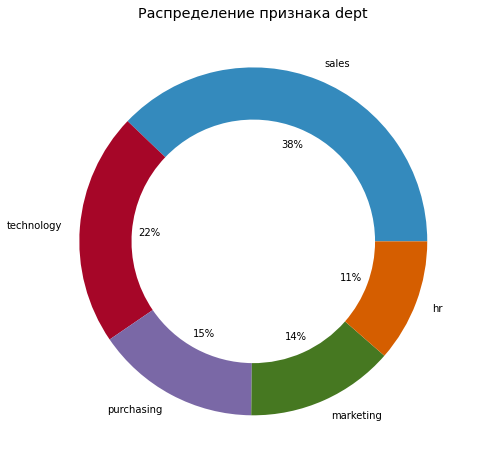

In [26]:
creating_graph(df, 'dept')

Наиболее многочисленным является отдел продаж (sales), в котором работает 1512 сотрудников.  На втором месте по численности находится отдел технологий (technology) с 866 сотрудниками. Далее следуют отделы закупок (purchasing, 610 сотрудников), маркетинга (marketing, 550 сотрудников) и HR (hr, 456 сотрудников).

**level**

junior    1894
middle    1744
senior     358
Name: level, dtype: int64


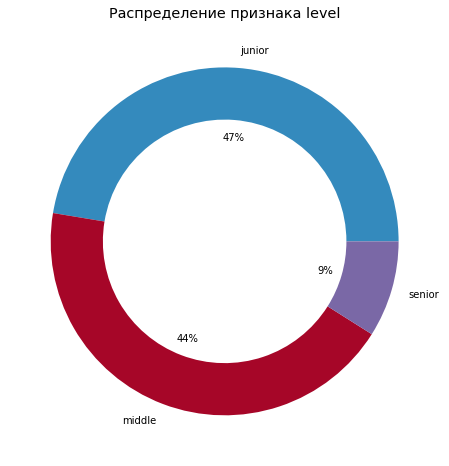

In [27]:
creating_graph(df, 'level')

Большинство сотрудников компании относятся к уровням junior (1894 человека) и middle (1744 человека).  Доля сотрудников уровня senior значительно меньше (358 человек).

**workload**

medium    2066
low       1200
high       734
Name: workload, dtype: int64


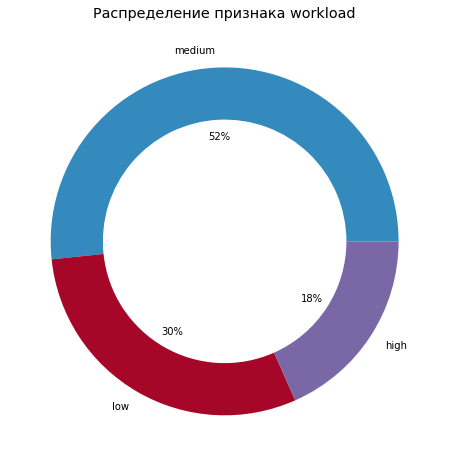

In [28]:
creating_graph(df, 'workload')

Более половины сотрудников (2066 человек) испытывают средний уровень загруженности (medium).  Значительная часть сотрудников (1200 человек) имеет низкий уровень загруженности (low).  Высокий уровень загруженности (high) наблюдается у 734 сотрудников, что составляет наименьшую долю.

**employment_years**

count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


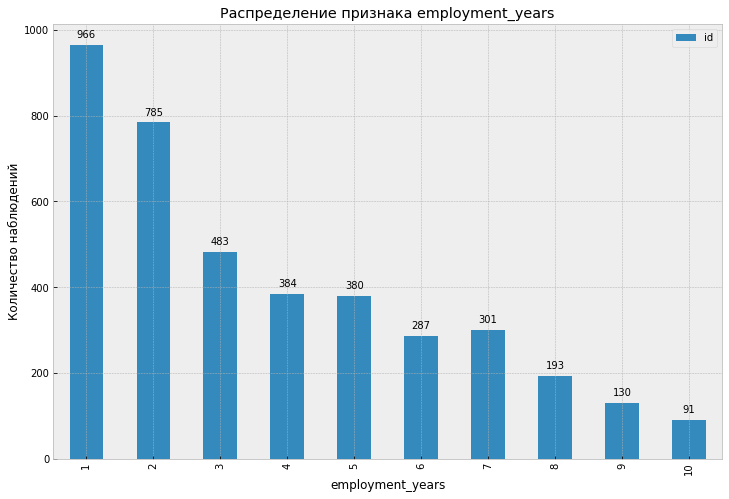

In [29]:
creating_graph(df, 'employment_years')

Минимальная длительность работы составляет 1 год, максимальная - 10 лет. Медиана (50% сотрудников) равна 3 годам, что означает, что половина сотрудников работает в компании 3 года или меньше. 

25% сотрудников работают в компании 2 года или меньше (первый квартиль), а 75% сотрудников - 6 лет или меньше (третий квартиль).  Это говорит о том, что большая часть сотрудников имеет относительно небольшой опыт работы в компании

**last_year_promo**

no     3880
yes     120
Name: last_year_promo, dtype: int64


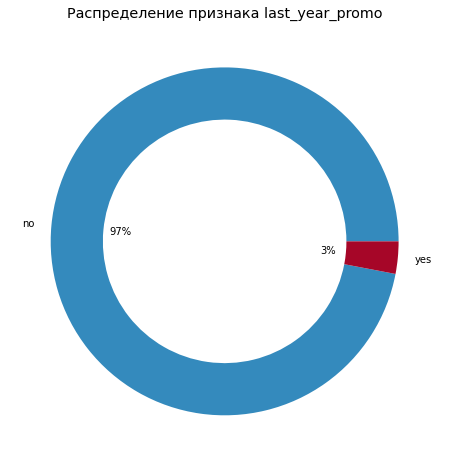

In [30]:
creating_graph(df, 'last_year_promo')

Представленные данные показывают, что подавляющее большинство сотрудников (3880 человек) не получали повышения за последний год. Лишь небольшая часть сотрудников (120 человек) была повышена. 

**last_year_violations**

no     3441
yes     559
Name: last_year_violations, dtype: int64


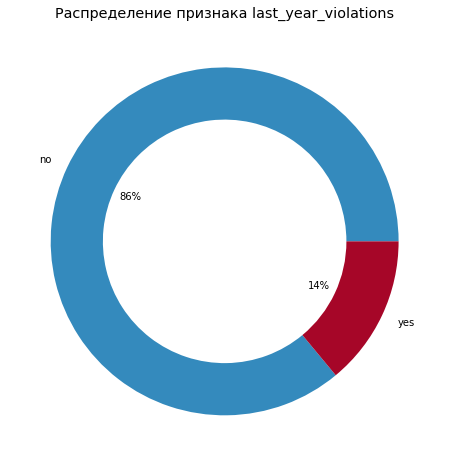

In [31]:
creating_graph(df, 'last_year_violations')

Представленные данные показывают, что большинство сотрудников (3441 человек) не нарушали трудовой договор за последний год.  Однако,  значительная часть сотрудников (559 человек) имели нарушения.

**supervisor_evaluation**

count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


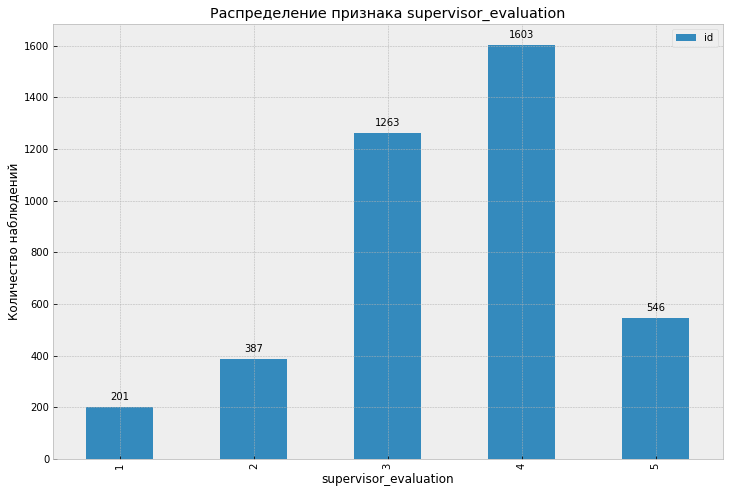

In [32]:
creating_graph(df, 'supervisor_evaluation')

Данные описывают распределение оценок качества работы сотрудников, которые были даны руководителями, а также предоставляют детальную информацию о количестве сотрудников, получивших каждую оценку.

Оценка качества работы представлена по 5-балльной шкале, где 1 - самая низкая оценка, а 5 - самая высокая.

Медиана (50% сотрудников) равна 4, что означает, что половина сотрудников получила оценку 4 или выше. Это свидетельствует о том, что руководители в целом положительно оценивают работу своих подчиненных.

Наиболее часто встречающаяся оценка - 4 (1603 сотрудника).  Следующая по частоте - 3 (1263 сотрудника).  Оценки 1 и 2 встречаются реже всего (201 и 387 сотрудников соответственно).

**salary**

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64


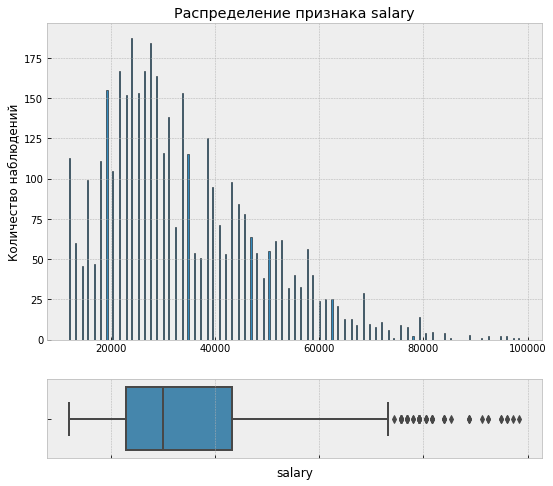

In [33]:
creating_graph(df, 'salary')

Зарплаты 4000 сотрудников варьируются от 12000 до 98400, со средней зарплатой 33926.7. 

**job_satisfaction_rate**

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


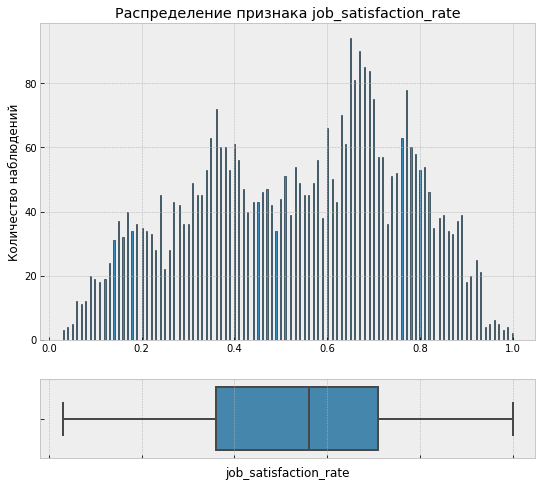

In [34]:
creating_graph(df, 'job_satisfaction_rate')

Уровень удовлетворенности работой измеряется по шкале от 0 до 1, где 1 означает максимальную удовлетворенность. Средний уровень удовлетворенности  слегка выше среднего:  Значение 0.53  указывает на то, что в среднем сотрудники  скорее удовлетворены,  чем нет.  Большинство сотрудников имеют  уровень удовлетворенности  выше среднего:  Медиана (0.56)  выше  среднего значения (0.53).
Диапазон  уровней  удовлетворенности  широкий:  минимальное  значение (0.03)  и  максимальное (1.00)  демонстрируют, что  есть  сотрудники,  которые  крайне  недовольны  своей  работой,  и  те,  кто  полностью  удовлетворен.

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

Для получения более детальной картины, рекомендуется провести дополнительные опросы сотрудников, фокусируясь на отдельных аспектах их рабочего опыта.  Например, можно оценить удовлетворенность заработной платой, взаимоотношениями в коллективе, взаимодействием с руководством и другими значимыми факторами.

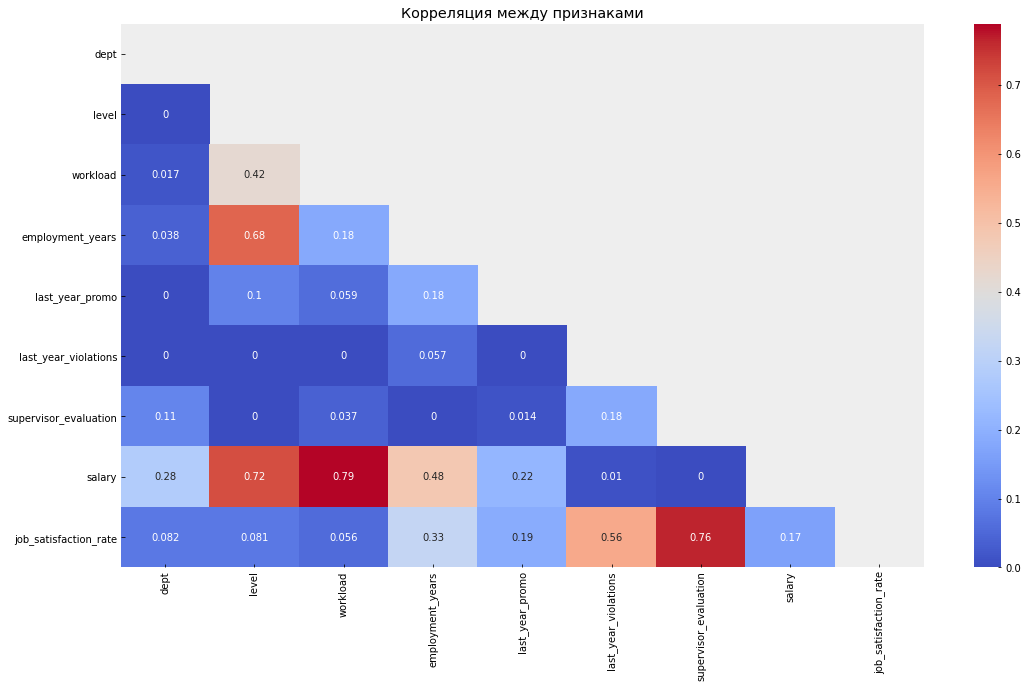

In [35]:
nam_col_names = df.drop('id', axis=1).select_dtypes(include='number').columns.tolist()

phik_matrix = df.drop('id', axis=1).phik_matrix(interval_cols=nam_col_names)

mask = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(18, 10))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', mask=mask)
plt.title('Корреляция между признаками')
plt.show()

Наиболее сильная корреляция с целевым признаком (уровнем удовлетворенности работой) наблюдается у переменной "supervisor_evaluation" (оценка качества работы, данная руководителем), коэффициент корреляции составляет 0.76.  Это может указывать на  значительное влияние взаимоотношений с руководством на удовлетворенность сотрудников.  Гипотетически, низкая оценка руководителя может демотивировать сотрудника и  снижать его желание работать в данной атмосфере, и наоборот, высокая оценка может способствовать повышению мотивации и удовлетворенности.


Второй по силе корреляции фактор -  "last_year_violations" (нарушение трудового договора за последний год), коэффициент корреляции 0.56.  Возможно,  нарушения трудового договора  являются следствием  низкой  мотивации  и  отсутствия  интереса  к работе.

Мультиколлинеарность  и утечка целевого признака в  данных  отсутствует.

<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> 
    
Структура персонала:


* Отделы:  Наиболее  многочисленными  являются  отделы  продаж (1512  сотрудников)  и  технологий (866  сотрудников).  Остальные  отделы  значительно  меньше.
* Уровни:  Большинство  сотрудников  относятся  к  уровням  junior (1894)  и  middle (1744).  Senior  сотрудников  значительно  меньше (358).
* Загруженность:  Более  половины  сотрудников (2066)  имеют  средний  уровень  загруженности.  Значительная  часть (1200)  имеет  низкий  уровень  загруженности.


Опыт работы:


* Стаж:  Медиана  стажа  работы  составляет  3  года.  Большинство  сотрудников  работают  в  компании  относительно  недолго (до  6  лет).


Карьера:


* Повышения:  Подавляющее  большинство  сотрудников (3880)  не  получали  повышения  за  последний  год.
* Нарушения:  Большинство  сотрудников (3441)  не  нарушали  трудовой  договор  за  последний  год,  но  значительная  часть (559)  имела  нарушения.


Оценка  работы:


* Оценки  руководителей:  Медиана  оценки  качества  работы  составляет  4  балла  (по  5-балльной  шкале).  Руководители  в  целом  положительно  оценивают  работу  сотрудников.  Наиболее  частые  оценки -  4  и  3.


Заработная  плата:


* Зарплаты:  Зарплаты  варьируются  от  12000  до  98400,  со  средней  зарплатой  33926.7.  Наблюдается  значительный  разброс  в  уровне  зарплат.
    
Уровень удовлетворенности:


* Средний уровень:  Уровень  удовлетворенности  работой  в  компании  в  целом  можно  оценить  как  удовлетворительный (среднее  значение  0.53  по  шкале  от  0  до  1).
* Разброс:  Наблюдается  значительный  разброс  в  уровнях  удовлетворенности  –  есть  как  крайне  недовольные,  так  и  полностью  удовлетворенные  сотрудники.


Факторы,  влияющие  на  удовлетворенность:


* Оценка  руководителя:  Наиболее  сильная  корреляция  с  удовлетворенностью  наблюдается  у  оценки  качества  работы,  данной  руководителем (коэффициент  корреляции  0.76).  Это  подчеркивает  важность  позитивных  взаимоотношений  с  руководством  и  справедливой  оценки  труда.
* Нарушения  трудового  договора:  Нарушения  трудового  договора  также  связаны  с  удовлетворенностью (коэффициент  корреляции  0.56),  что  может  указывать  на  низкую  мотивацию  и  негативное  отношение  к  работе.
</div>

### Подготовка данных

Вместо числовых индексов в df, X_test_1 и y_test_1 будем использовать идентификаторы (ID) сотрудников. Затем объединим X_test_1 и y_test_1 в один датафрейм, чтобы обеспечить соответствие индексов. После этого разделим полученные таблицы на обучающую и тестовую выборки. 

In [36]:
df = df.set_index('id')
X_test_1 = X_test_1.set_index('id')
y_test_1 = y_test_1.set_index('id')

In [37]:
print(f'Размер X_test_1: {X_test_1.shape}')
full_test = X_test_1.merge(y_test_1, right_index=True, left_index=True)
print(f'Размер full_test: {full_test.shape}')

Размер X_test_1: (2000, 8)
Размер full_test: (2000, 9)


In [38]:
X_train_1 = df.drop('job_satisfaction_rate', axis=1)
y_train_1 = df['job_satisfaction_rate']

In [39]:
X_test_1 = full_test.drop('job_satisfaction_rate', axis=1)
y_test_1 = full_test['job_satisfaction_rate']

In [40]:
print(f'Размер X_train_1: {X_train_1.shape}')
print(f'Размер y_train_1: {y_train_1.shape}')
print()
print(f'Размер X_test_1: {X_test_1.shape}')
print(f'Размер y_test_1: {y_test_1.shape}')

Размер X_train_1: (4000, 8)
Размер y_train_1: (4000,)

Размер X_test_1: (2000, 8)
Размер y_test_1: (2000,)


Следующие переменные будут классифицированы как категориальные:

* dept: отдел, в котором работает сотрудник;
* last_year_promo: наличие повышения за последний год;
* last_year_violations: факт нарушения трудового договора за последний год.

Переменные level (уровень занимаемой должности) и workload (уровень загруженности сотрудника) будут рассматриваться как ранговые.

Остальные переменные, за исключением целевого признака, будут отнесены к числовым.

In [41]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = df.select_dtypes(include='number').columns.drop('job_satisfaction_rate').tolist()

Для предобработки данных будут использованы следующие методы:

Категориальные переменные:

* Кодирование с помощью OneHotEncoder.

Ранговые переменные:

* Кодирование с помощью OrdinalEncoder.

Числовые переменные:

* Масштабирование с использованием MinMaxScaler, StandardScaler или passthrough (выбор будет осуществляться с помощью RandomizedSearchCV).

Обработка пропусков:

* Заполнение пропусков в данных будет производиться с помощью SimpleImputer, используя модальное значение.

In [42]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> в разделе "Подготовка данных" были выполнены следующие действия:

1. Преобразование индексов: Числовые индексы в датафреймах df, X_test_1 и y_test_1 были заменены на идентификаторы (ID) сотрудников. 
2. Объединение данных: Датафреймы X_test_1 и y_test_1 были объединены для обеспечения соответствия индексов.
3. Разделение на выборки:  Объединенный датафрейм, а также df, были разделены на обучающую и тестовую выборки.
4. Классификация признаков:  Переменные были классифицированы на категориальные (dept, last_year_promo, last_year_violations), ранговые (level, workload) и числовые (остальные, кроме целевого признака).
5. Выбор методов предобработки: 
    * Для категориальных признаков: OneHotEncoder.
    * Для ранговых признаков: OrdinalEncoder.
    * Для числовых признаков:  MinMaxScaler, StandardScaler или отсутствие масштабирования (passthrough) - выбор будет осуществляться с помощью RandomizedSearchCV.
6. Обработка пропусков:  Пропуски в данных будут заполнены с помощью SimpleImputer, используя модальное значение.
7. Создание пайплайнов: Были созданы пайплайны для подготовки данных и для объединения этапов подготовки данных с моделью машинного обучения.
</div>

### Обучение моделей

Цель данного раздела:

Разработать модель машинного обучения, способную предсказывать уровень удовлетворенности сотрудников работой в компании.  Целевым признаком является "уровень удовлетворенности".

Метрика оценки качества:

Для оценки качества модели будет использоваться метрика SMAPE (Symmetric Mean Absolute Percentage Error), заданная условием задачи.  Поскольку SMAPE не является стандартной метрикой в scikit-learn, её необходимо реализовать вручную с помощью функции make_scorer. Критерий успеха: SMAPE ≤ 15 на тестовой выборке.

In [43]:
def smape(y_test, y_pred):
    """
    Вход: y_test:  Массив или Series с фактическими значениями целевой переменной.
          y_pred:  Массив или Series с прогнозируемыми значениями целевой переменной.
          
    Выход: SMAPE
    """
    numerator = np.abs(y_test - y_pred)
    denominator = (np.abs(y_test) + np.abs(y_pred)) / 2
    diff = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator != 0)
    return np.mean(diff) * 100

smape_score = make_scorer(smape, greater_is_better=False)

В качестве моделей регрессии для решения задачи будут рассматриваться LinearRegression и DecisionTreeRegressor. 

In [44]:
param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 20),
        'models__min_samples_leaf': range(1, 6),
        'models__min_samples_split': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    }
]


In [45]:
best_model = 0
best_train_score = 0
best_test_score = 0

for grid in param_grid:
    
    print(grid['models'][0])
    
    randomized_search = RandomizedSearchCV(
        pipe_final, 
        grid, 
        scoring=smape_score, 
        random_state=RANDOM_STATE,
        cv=10,
        n_jobs=-1
    )
    randomized_search.fit(X_train_1, y_train_1)
    
    model = randomized_search.best_estimator_
    train_score = randomized_search.best_score_ * (-1)
    test_score = smape(y_test_1, randomized_search.best_estimator_.predict(X_test_1))
    
    if best_test_score == 0:
        best_model = model
        best_train_score = train_score
        best_test_score = test_score
    else:
        if best_test_score >= test_score:
            best_model = model
            best_train_score = train_score
            best_test_score = test_score
        else:
            pass
        
    #print(best_model)
    print(f'Лучшее значение SMAPE модели на тренировочной выборке: {train_score}')
    print(f'Лучшее значение SMAPE модели на тестовой выборке: {test_score}')
    print('__' * 50)

LinearRegression()
Лучшее значение SMAPE модели на тренировочной выборке: 27.766774211049768
Лучшее значение SMAPE модели на тестовой выборке: 25.576769700174506
____________________________________________________________________________________________________
DecisionTreeRegressor(random_state=42)
Лучшее значение SMAPE модели на тренировочной выборке: 14.376939298194932
Лучшее значение SMAPE модели на тестовой выборке: 13.558088260606024
____________________________________________________________________________________________________


In [46]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_befor...
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num', 'passthrough',
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=17, min_samples_leaf=3,
                                       min_samples_split=3, random_state=42))])

Наилучшие результаты продемонстрировала модель DecisionTreeRegressor с подобранными гиперпараметрами: max_depth=17 и min_samples_leaf=3.

DecisionTreeRegressor достигла значительно меньшего значения SMAPE как на тренировочной, так и на тестовой выборках по сравнению с LinearRegression. Это может быть обусловлено несколькими причинами:

1. Нелинейные зависимости в данных:

* DecisionTreeRegressor способна моделировать нелинейные зависимости между признаками и целевой переменной. Она строит дерево решений, разбивая данные на подгруппы на основе значений признаков, и для каждой подгруппы может предсказывать разные значения.
* LinearRegression предполагает линейную зависимость между признаками и целевой переменной. Если в данных присутствуют сложные нелинейные взаимодействия, линейная модель не сможет их адекватно описать и предсказания будут менее точными.

2. Взаимодействие признаков:

* DecisionTreeRegressor автоматически учитывает взаимодействие признаков при построении дерева решений. Например, она может обнаружить, что влияние одного признака на целевую переменную меняется в зависимости от значения другого признака.
* LinearRegression в базовой реализации не учитывает взаимодействие признаков.  Для этого необходимо вручную создавать новые признаки, которые представляют собой комбинации существующих признаков.

In [47]:
y_predict_1 = best_model.predict(X_test_1)

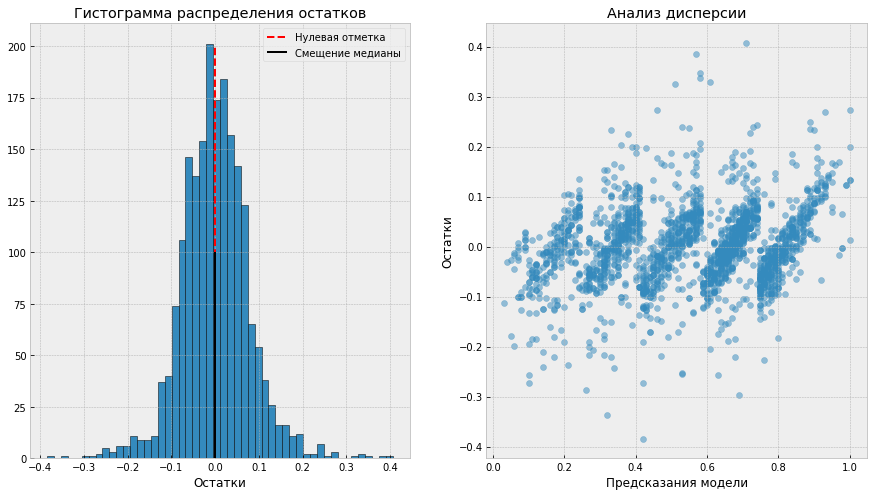

In [48]:
residuals = y_test_1 - y_predict_1
    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
axes[0].hist(residuals, bins=50, edgecolor='black')
zero = axes[0].vlines(x=0, colors='red', ymin=0, ymax=200, linestyles='--', label='Нулевая отметка')
median = axes[0].vlines(x=residuals.median(), colors='black', ymin=0, ymax=100, label='Смещение медианы')
axes[0].legend()
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(y_test_1, residuals, alpha=0.5)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Симметричное распределение остатков относительно нуля на графике свидетельствует о хорошем качестве модели. Это означает, что модель в среднем не завышает и не занижает предсказания, поскольку положительные и отрицательные отклонения от истинных значений уравновешивают друг друга.

Наблюдаемое смещение распределения остатков от меньших к большим значениям может быть связано с особенностями работы модели DecisionTreeRegressor.  Эта модель склонна к построению кусочно-постоянных функций, что может приводить к неравномерному распределению ошибок в различных диапазонах целевой переменной.

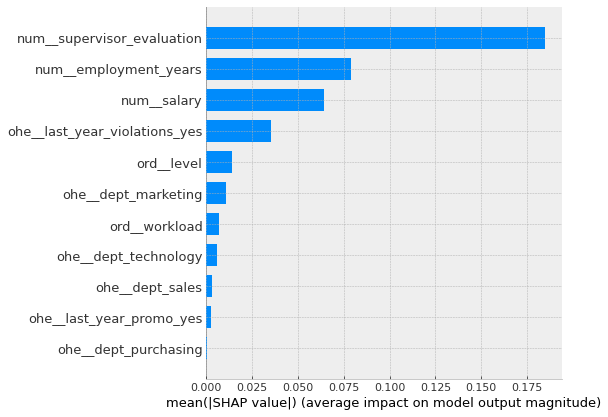

None

In [49]:
# Получение лучшей модели
best_pipeline = randomized_search.best_estimator_

# Извлечение модели из пайплайна
model = best_pipeline.named_steps['models']

X_train_shap = pd.DataFrame(
    pipe_final.named_steps['preprocessor'].fit_transform(X_train_1), 
    columns= pipe_final.named_steps['preprocessor'].get_feature_names_out()
)
X_test_shap = pd.DataFrame(
    pipe_final.named_steps['preprocessor'].transform(X_test_1), 
    columns= pipe_final.named_steps['preprocessor'].get_feature_names_out()
)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_shap)
display(shap.summary_plot(shap_values, X_test_shap, plot_type="bar"))


Модель DecisionTreeRegressor определила следующие признаки как наиболее важные для предсказания уровня удовлетворенности сотрудников:

1. supervisor_evaluation: оценка качества работы сотрудника, предоставленная руководителем.
2. employment_years: стаж работы в компании (в годах).
3. salary: ежемесячная заработная плата сотрудника.

<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> цель данного раздела заключалась в разработке модели машинного обучения для прогнозирования уровня удовлетворенности сотрудников работой в компании. В качестве метрики оценки качества использовалась SMAPE (Symmetric Mean Absolute Percentage Error), а критерием успеха являлось достижение значения SMAPE ≤ 15 на тестовой выборке.

В исследовании были рассмотрены две модели регрессии: LinearRegression и DecisionTreeRegressor. 

Наилучшие результаты продемонстрировала модель DecisionTreeRegressor с подобранными гиперпараметрами (max_depth=17 и min_samples_leaf=3), которая достигла значительно меньшего значения SMAPE как на тренировочной, так и на тестовой выборках по сравнению с LinearRegression.  

Превосходство DecisionTreeRegressor объясняется её способностью моделировать нелинейные зависимости и взаимодействие признаков, которые, вероятно, присутствуют в данных. LinearRegression, предполагающая линейную зависимость между признаками и целевой переменной, не смогла адекватно описать сложные взаимосвязи в данных.

Анализ остатков модели DecisionTreeRegressor показал симметричное распределение относительно нуля, что свидетельствует о хорошем качестве модели и отсутствии систематических ошибок в предсказаниях. Некоторое смещение распределения остатков от меньших к большим значениям может быть связано с особенностями работы DecisionTreeRegressor, которая склонна к построению кусочно-постоянных функций. 

Модель DecisionTreeRegressor определила три наиболее важных признака для предсказания уровня удовлетворенности: 

1. Оценка руководителя (supervisor_evaluation):  качество работы,  оцененное  руководителем,  оказывает  существенное  влияние  на  удовлетворенность  сотрудников.
2. Стаж работы (employment_years):  длительность  работы  в  компании  также  играет  важную  роль  в  формировании  удовлетворенности.
3. Заработная плата (salary):  уровень  зарплаты  является  одним  из  ключевых  факторов,  влияющих  на  удовлетворенность  сотрудников.
</div>

### Выводы по задаче

<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> исходные данные, представленные в датафреймах df, X_test_1 и y_test_1, характеризуются хорошим качеством и готовы к дальнейшей обработке для построения модели машинного обучения.

Ключевые особенности данных:

* Минимальное количество пропусков: Пропуски обнаружены только в столбцах dept и level датафреймов df  и  X_test_1  и  представлены  в  небольшом  количестве.
* Отсутствие аномалий: Числовые признаки находятся в ожидаемых диапазонах, аномальные значения не выявлены.
* Соответствие типов данных: Типы данных во всех датафреймах соответствуют ожидаемым.
* Незначительные расхождения в X_test_1: В X_test_1  обнаружены  небольшие  расхождения  в  количестве  уникальных  значений  в  столбцах dept  и  workload  по  сравнению  с  df,  которые  могут  быть  устранены  на  этапе  предобработки.
* Согласованность данных в X_test_1 и y_test_1: Количество наблюдений и диапазон значений id  в  X_test_1  и  y_test_1  совпадают,  что  подтверждает  согласованность  данных.
* Корректные названия столбцов: Названия столбцов во всех датафреймах соответствуют стандартам именования.

Выявленные проблемы и их решение:

* Пропущенные значения в X_test_1: Обнаружены пропущенные значения категориальных признаков, представленные пробелами. Пропуски были заменены модальным значением соответствующего столбца.
* Опечатка в столбце level: В таблицах X_test_1  и  df  в  столбце  level  выявлена  опечатка  ("sinior"  вместо  "senior").  Опечатка  была  исправлена.

Анализ структуры данных выявил следующие особенности:

* Неравномерное распределение сотрудников по отделам и уровням: Отделы продаж и технологий являются наиболее многочисленными, а большинство сотрудников относятся к уровням junior и middle.
* Средний стаж работы: Медиана стажа работы составляет 3 года.
* Низкий процент повышений: Большинство сотрудников не получали повышения за последний год.
* Значительная доля нарушений трудового договора:  Около 14% сотрудников имели нарушения трудового договора за последний год.
* Положительные оценки руководителей:  Руководители в целом положительно оценивают работу сотрудников (медиана оценки - 4 балла).
* Значительный разброс зарплат:  Зарплаты варьируются от 12000 до 98400.
* Средний уровень удовлетворенности:  Уровень удовлетворенности работой в целом можно оценить как удовлетворительный (среднее значение 0.53).
* Сильная корреляция удовлетворенности с оценкой руководителя и нарушениями трудового договора:  Оценка руководителя и нарушения трудового договора  являются  наиболее  значимыми  факторами,  связанными  с  удовлетворенностью  сотрудников.

В разделе "Подготовка данных" были выполнены следующие шаги для подготовки данных к построению модели машинного обучения для прогнозирования уровня удовлетворенности сотрудников:

1. Преобразование индексов: Числовые индексы в датафреймах df, X_test_1 и y_test_1 были заменены на идентификаторы (ID) сотрудников для обеспечения согласованности данных.
2. Объединение данных: Датафреймы X_test_1 и y_test_1 были объединены для обеспечения соответствия индексов и создания единого тестового набора данных.
3. Разделение на выборки:  Данные были разделены на обучающую и тестовую выборки для оценки качества модели на невидимых данных.
4. Классификация признаков:  Переменные были классифицированы на категориальные, ранговые и числовые для выбора подходящих методов предобработки.
5. Выбор методов предобработки: 
    * Для категориальных признаков: OneHotEncoder (для создания фиктивных переменных).
    * Для ранговых признаков: OrdinalEncoder (для кодирования порядковых значений).
    * Для числовых признаков:  MinMaxScaler, StandardScaler или отсутствие масштабирования (passthrough) - выбор оптимального метода будет осуществляться с помощью RandomizedSearchCV.
6. Обработка пропусков:  Пропуски в данных будут заполнены с помощью SimpleImputer, используя модальное значение для категориальных и ранговых признаков.
7. Создание пайплайнов: Были созданы пайплайны для подготовки данных и для объединения этапов подготовки данных с моделью машинного обучения, что упрощает процесс обучения и оценки модели.

После подготовки данных были рассмотрены две модели регрессии: LinearRegression и DecisionTreeRegressor.

Наилучшие результаты продемонстрировала модель DecisionTreeRegressor с подобранными гиперпараметрами (max_depth=17 и min_samples_leaf=3), которая достигла значительно меньшего значения SMAPE (Symmetric Mean Absolute Percentage Error) как на тренировочной, так и на тестовой выборках по сравнению с LinearRegression,  успешно  выполнив  критерий  успеха  (SMAPE ≤ 15).

Превосходство DecisionTreeRegressor обусловлено её способностью эффективно моделировать нелинейные зависимости и взаимодействие признаков, которые, вероятно, присутствуют в данных о  удовлетворенности  сотрудников.  LinearRegression,  основанная  на  предположении  о  линейной  зависимости  между  признаками  и  целевой  переменной,  не  смогла  адекватно  описать  сложные  взаимосвязи  в  данных  и  показала  худшее  качество  прогнозирования.

Анализ остатков модели DecisionTreeRegressor подтвердил  ее  высокое  качество:  симметричное  распределение  остатков  относительно  нуля  свидетельствует  об  отсутствии  систематических  ошибок  в  предсказаниях.  Небольшое  смещение  распределения  от  меньших  к  большим  значениям  может  быть  связано  со  спецификой  работы  DecisionTreeRegressor,  которая  склонна  к  построению  кусочно-постоянных  функций.

Модель DecisionTreeRegressor  выделила  три  наиболее  важных  признака  для  прогнозирования  уровня  удовлетворенности  сотрудников:

1. Оценка руководителя (supervisor_evaluation):  Качество  работы,  оцененное  руководителем,  оказывает  существенное  влияние  на  удовлетворенность  сотрудников.
2. Стаж работы (employment_years):  Длительность  работы  в  компании  также  играет  важную  роль  в  формировании  удовлетворенности.
3. Заработная плата (salary):  Уровень  зарплаты  является  одним  из  ключевых  факторов,  влияющих  на  удовлетворенность  сотрудников.
</div>

## Задача: предсказание увольнения сотрудника из компании

### Загрузка данных

In [50]:
try:
    df_quit = pd.read_csv('train_quit.csv')
except:
    df_quit = pd.read_csv('/datasets/train_quit.csv')
    
try:
    y_test_2 = pd.read_csv('test_target_quit.csv')
except:
    y_test_2 = pd.read_csv('/datasets/test_target_quit.csv')

In [51]:
df_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [52]:
df_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [53]:
df_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


In [54]:
df_quit.describe(include='object')

,dept,level,workload,last_year_promo,last_year_violations,quit
count,4000,4000,4000,4000,4000,4000
unique,5,3,3,2,2,2
top,sales,junior,medium,no,no,no
freq,1438,1949,2118,3887,3455,2872


Структура текущего датафрейма идентична датафрейму df из предыдущей задачи (4000 строк и 10 столбцов), за исключением следующего:

* Целевой признак: Вместо job_satisfaction_rate (уровень удовлетворенности сотрудника работой) используется quit (факт увольнения сотрудника из компании).
* Качество данных:  Датафрейм не содержит пропусков и аномальных значений, типы данных корректны.

Уникальные значения признаков будут подробно рассмотрены на этапе предобработки данных. 

In [55]:
y_test_2.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [56]:
y_test_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [57]:
y_test_2.describe(include='object')

,quit
count,2000
unique,2
top,no
freq,1436


Тестовая выборка с целевым признаком содержит 2000 наблюдений и два столбца: id (идентификатор сотрудника) и quit (факт увольнения). В дальнейшем идентификаторы сотрудников будут использоваться в качестве индексов датафрейма.

In [58]:
X_test_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1997 non-null   object
 2   level                  1999 non-null   object
 3   workload               1999 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Датафрейм X_test_2 был создан путем копирования X_test_1 из этапа предобработки данных первой задачи.  Остается только обработать пропуски в X_test_2, что будет выполнено в пайплайне с использованием метода замены на модальное значение.

<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> в данном разделе был проведен предварительный анализ данных. Было установлено, что:

1. Структура данных:  Текущий датафрейм (4000 строк и 10 столбцов) аналогичен датафрейму из предыдущей задачи, за исключением целевого признака (теперь это quit - факт увольнения сотрудника) и отсутствия пропусков и аномалий.
2. Тестовая выборка: Содержит 2000 наблюдений с идентификаторами сотрудников (id) и целевым признаком (quit). Идентификаторы будут использованы в качестве индексов.
3. Подготовка тестовой выборки: Датафрейм X_test_2 был скопирован из предыдущей задачи,  и для него будет выполнена обработка пропусков (замена на модальное значение) в рамках пайплайна.

Следующим этапом будет детальное изучение уникальных значений признаков и  предобработка данных.
</div>

### Предобработка данных

Для анализа уникальных значений в датафреймах df_quit, X_test_2 и y_test_2 будет применена функция search_duplicated(), разработанная в первой задаче.  

In [59]:
search_duplicated(df_quit)

Количество дубликатов в: 0

Уникальные значения столбца dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения столбца level: ['middle' 'junior' 'sinior']
Уникальные значения столбца workload: ['high' 'medium' 'low']
Уникальные значения столбца last_year_promo: ['no' 'yes']
Уникальные значения столбца last_year_violations: ['no' 'yes']
Уникальные значения столбца quit: ['no' 'yes']


In [60]:
search_duplicated(X_test_2)

Количество дубликатов в: 0

Уникальные значения столбца dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
Уникальные значения столбца level: ['junior' 'middle' 'senior' nan]
Уникальные значения столбца workload: ['medium' 'low' 'high' nan]
Уникальные значения столбца last_year_promo: ['no' 'yes']
Уникальные значения столбца last_year_violations: ['no' 'yes']


In [61]:
search_duplicated(y_test_2)

Количество дубликатов в: 0

Уникальные значения столбца quit: ['yes' 'no']


В датафрейме df_quit обнаружена опечатка в значении признака, предположительно, должно быть senior вместо sinior.  Эта ошибка будет исправлена. В остальном данные не содержат проблем.

In [62]:
df_quit['level'] = df_quit['level'].replace('sinior', 'senior')

In [63]:
search_duplicated(df_quit)

Количество дубликатов в: 0

Уникальные значения столбца dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения столбца level: ['middle' 'junior' 'senior']
Уникальные значения столбца workload: ['high' 'medium' 'low']
Уникальные значения столбца last_year_promo: ['no' 'yes']
Уникальные значения столбца last_year_violations: ['no' 'yes']
Уникальные значения столбца quit: ['no' 'yes']


<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> проведен анализ уникальных значений в датафреймах df_quit, X_test_2 и y_test_2 с использованием функции search_duplicated(). В результате анализа была выявлена единственная проблема: опечатка в значении признака в датафрейме df_quit (sinior вместо предположительно корректного senior). Данная ошибка будет исправлена.

В целом, данные признаны качественными и готовыми для проведения дальнейшего исследовательского и корреляционного анализа.

</div>

### Исследовательский и корреляционный анализ данных

Цели данного пункта:

1. Составить портрет «уволившегося сотрудника».
2. Проверить утверждение о влиянии уровня удовлетворенности работой на вероятность увольнения.

Датафрейм df_quit будет разделен на две подвыборки:

1. Сотрудники, которые уволились.
2. Сотрудники, которые не уволились.

Дальнейший анализ будет сфокусирован на подвыборке сотрудников, которые уволились в сравнении с не уволенными.


In [64]:
no_quit = df_quit[df_quit['quit'] == 'no']
yes_quit = df_quit[df_quit['quit'] == 'yes']

no     2872
yes    1128
Name: quit, dtype: int64


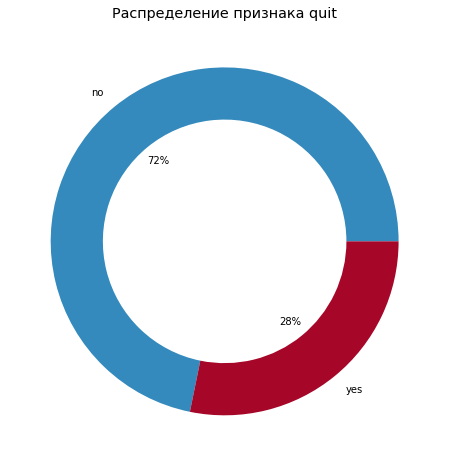

In [65]:
creating_graph(df_quit, 'quit')

Целевой признак quit (факт увольнения сотрудника) имеет несбалансированное распределение:

* 2872 сотрудника (71.8%) не уволились (значение no).
* 1128 сотрудников (28.2%) уволились (значение yes).

Это означает, что класс "не уволился" значительно преобладает над классом "уволился". 

Данный факт необходимо учитывать при построении модели, так как несбалансированность классов может привести к смещению модели в сторону превалирующего класса и снижению качества предсказаний для миноритарного класса.

В соответствии с условиями задачи, целевой метрикой для оптимизации является ROC-AUC. 

Метрика ROC-AUC считается достаточно устойчивой к дисбалансу классов.  Она оценивает способность модели различать классы, основываясь на ранжировании объектов по вероятности принадлежности к положительному классу. 


**dept**

sales         407
technology    276
purchasing    166
marketing     163
hr            116
Name: dept, dtype: int64


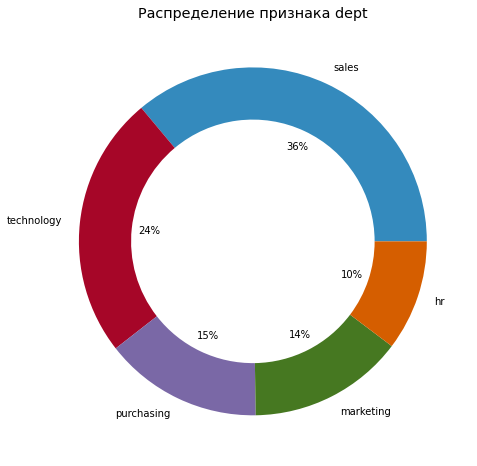

In [66]:
creating_graph(yes_quit, 'dept')

sales         1031
technology     652
purchasing     422
marketing      419
hr             348
Name: dept, dtype: int64


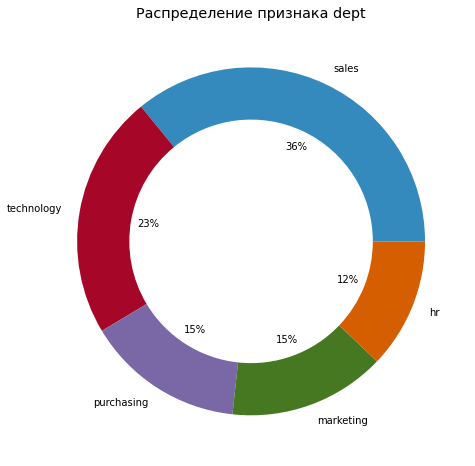

In [67]:
creating_graph(no_quit, 'dept')

Отдел продаж (sales) лидирует как по количеству уволенных (407), так и по количеству неуволенных (1031) сотрудников.  Это может быть связано с высокой текучестью кадров в данном отделе, либо с большим количеством сотрудников в этом отделе по сравнению с другими. 

Отделы marketing (163) и hr (116) имеют наименьшее количество уволенных сотрудников. И наименьшее количество сотрудников.

Выделить отдел с наибольшим количеством уволенных сотрудников затруднительно, поскольку количество увольнений в каждом отделе  пропорционально общему размеру отдела.

**level**

junior    1003
middle     108
senior      17
Name: level, dtype: int64


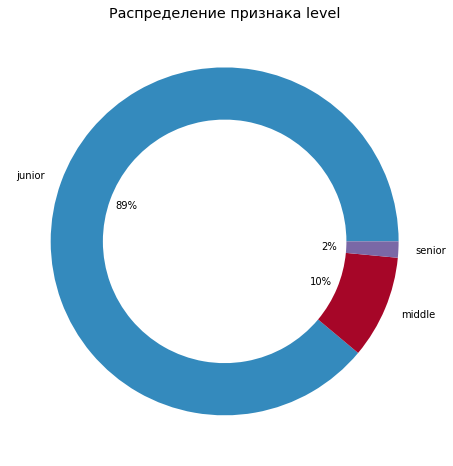

In [68]:
creating_graph(yes_quit, 'level')

middle    1586
junior     946
senior     340
Name: level, dtype: int64


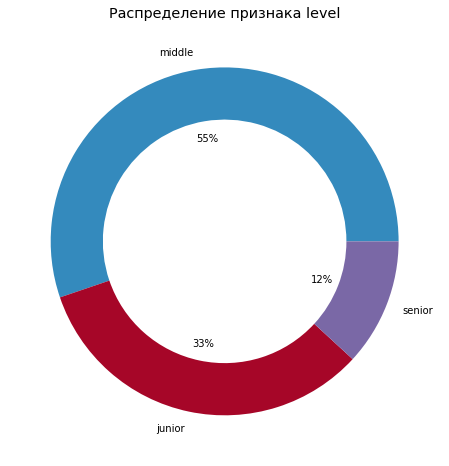

In [69]:
creating_graph(no_quit, 'level')

* Среди уволенных сотрудников преобладают сотрудники уровня junior (1003).  Сотрудники уровня junior могут увольняться в поисках более высоких должностей и  лучших возможностей для развития. Или могут быть менее удовлетворены уровнем заработной платы.
* Наименьшее количество уволенных сотрудников наблюдается среди senior (17). 

**workload**

low       519
medium    488
high      121
Name: workload, dtype: int64


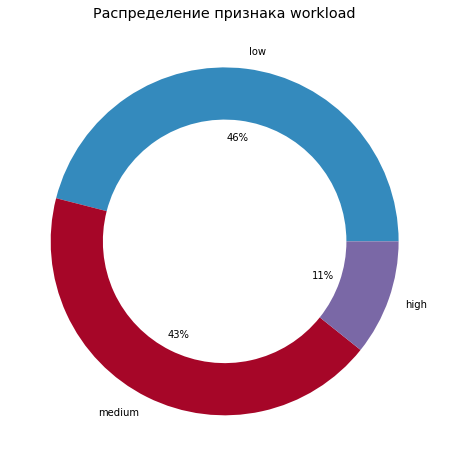

In [70]:
creating_graph(yes_quit, 'workload')

medium    1630
low        689
high       553
Name: workload, dtype: int64


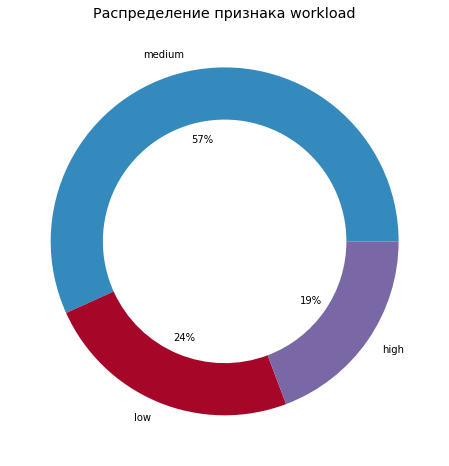

In [71]:
creating_graph(no_quit, 'workload')

* Среди уволенных сотрудников преобладают сотрудники с низким (519) и средним (488) уровнем загруженности. Сотрудники с низким уровнем загруженности могут испытывать недостаток интересных задач и  чувствовать себя недооцененными, что может привести к увольнению. Сотрудники со средним уровнем загруженности могут сталкиваться с выгоранием, если  не получают достаточной поддержки и  признания своих заслуг.
* Среди неуволенных сотрудников преобладают сотрудники со средним (1630)  и высоким (553) уровнем загруженности. 
* Наименьшее количество уволенных сотрудников наблюдается среди тех, у кого высокая загруженность (121). Сотрудники с высокой загруженностью могут быть более вовлечены в работу и  мотивированы на достижение результатов, что снижает вероятность увольнения.

**employment_years**

count    1128.000000
mean        1.844858
std         1.274920
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: employment_years, dtype: float64


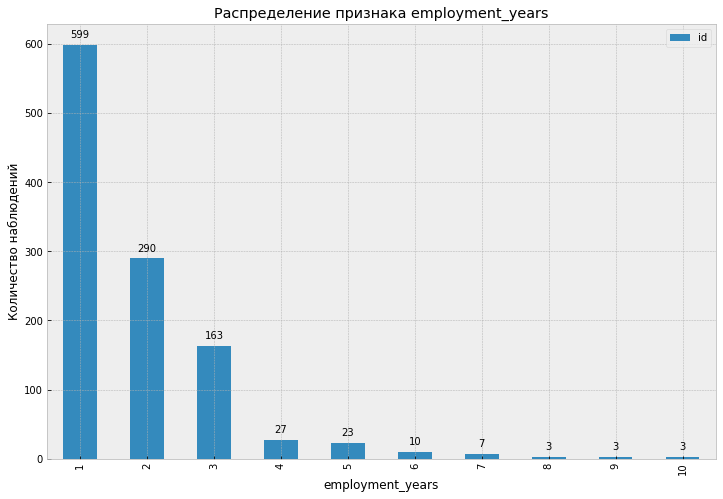

In [72]:
creating_graph(yes_quit, 'employment_years')

count    2872.000000
mean        4.430710
std         2.544635
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


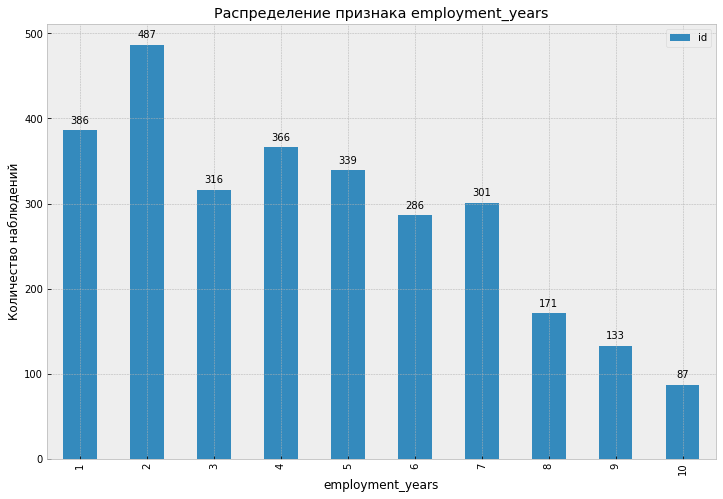

In [73]:
creating_graph(no_quit, 'employment_years')

* Средняя длительность работы уволенных сотрудников (1.84 года) значительно меньше, чем у неуволенных (4.43 года).
* Медиана длительности работы у уволенных сотрудников (1 год) также ниже, чем у неуволенных (4 года). Это означает, что половина уволенных сотрудников проработала в компании всего 1 год, в то время как половина неуволенных сотрудников проработала 4 и более лет.

Увольнения чаще происходят среди сотрудников с небольшим стажем работы. Это может быть связано с тем, что новым сотрудникам требуется время для адаптации,  и  не все успешно проходят этот период.

Сотрудники, проработавшие в компании недолго, могут быть менее удовлетворены условиями труда (например,  уровнем заработной платы,  возможностями для развития) и  принимают решение об увольнении.

**last_year_promo**

no     1127
yes       1
Name: last_year_promo, dtype: int64


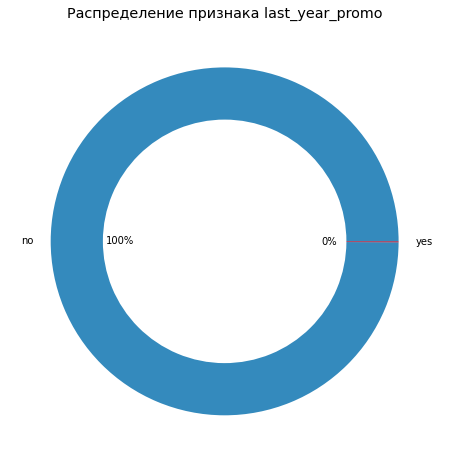

In [74]:
creating_graph(yes_quit, 'last_year_promo')

no     2760
yes     112
Name: last_year_promo, dtype: int64


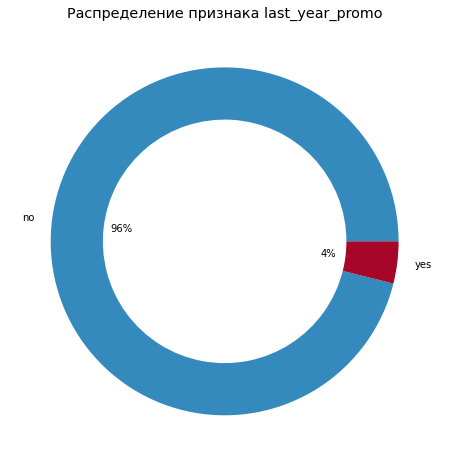

In [75]:
creating_graph(no_quit, 'last_year_promo')

Подавляющее большинство уволенных сотрудников (1127 из 1128) не получали повышение за последний год.

Среди неуволенных сотрудников также преобладают те, кто не получал повышение (2760 из 2872), однако доля получивших повышение (112 из 2872)  значительно выше, чем среди уволенных (1 из 1128)

**last_year_violations**

no     900
yes    228
Name: last_year_violations, dtype: int64


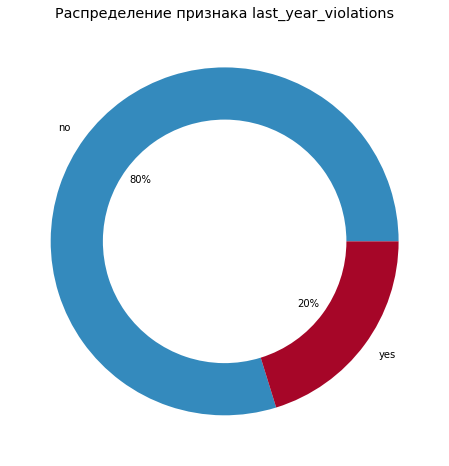

In [76]:
creating_graph(yes_quit, 'last_year_violations')

no     2555
yes     317
Name: last_year_violations, dtype: int64


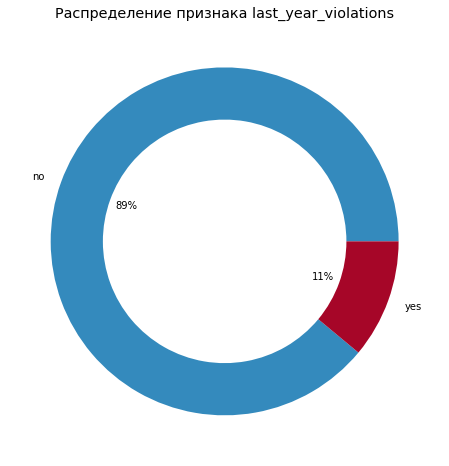

In [77]:
creating_graph(no_quit, 'last_year_violations')

Среди уволенных сотрудников доля нарушивших трудовой договор (228 из 1128) примерно в 2 раза выше, чем среди неуволенных (317 из 2872).

Сотрудники, нарушающие трудовой договор,  могут быть уволены по этой причине.

**supervisor_evaluation**

count    1128.000000
mean        3.046099
std         0.973291
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


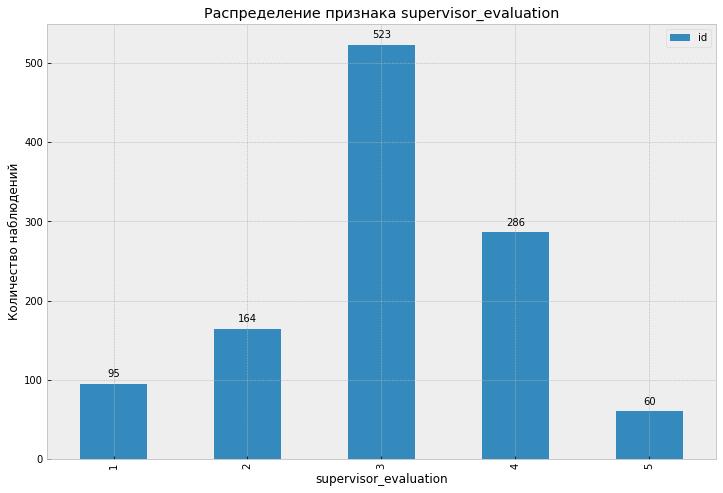

In [78]:
creating_graph(yes_quit, 'supervisor_evaluation')

count    2872.000000
mean        3.643106
std         0.965295
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


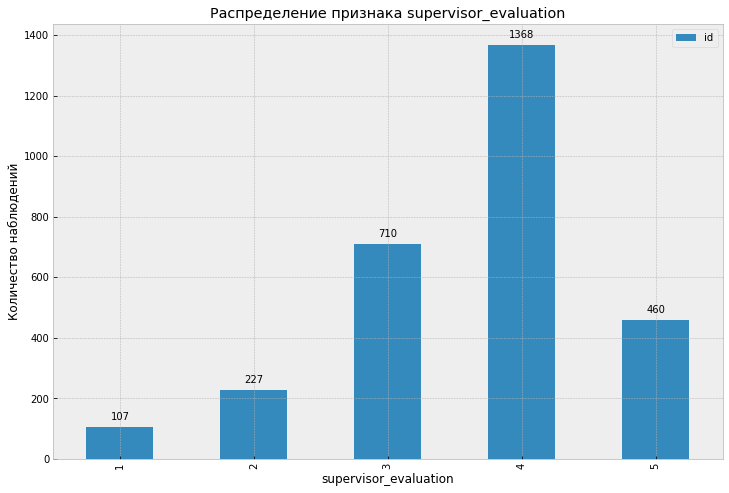

In [79]:
creating_graph(no_quit, 'supervisor_evaluation')

Медиана оценки качества работы у уволенных сотрудников (3) ниже, чем у неуволенных (4). Это означает, что половина уволенных сотрудников получила оценку 3 и ниже, в то время как половина неуволенных сотрудников получила оценку 4 и выше.

Сотрудники, получившие низкие оценки, могут быть демотивированы и сами принимать решение об увольнении.

Возможно, руководители более строго оценивают сотрудников, которые планируют увольняться.

**salary**

count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64


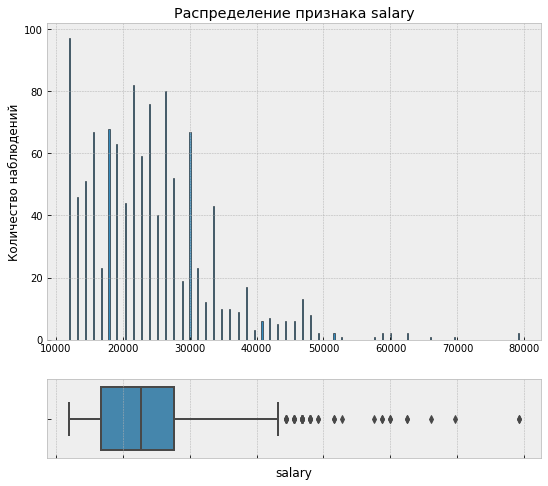

In [80]:
creating_graph(yes_quit, 'salary')

count     2872.000000
mean     37702.228412
std      15218.977339
min      12000.000000
25%      25200.000000
50%      34800.000000
75%      46800.000000
max      96000.000000
Name: salary, dtype: float64


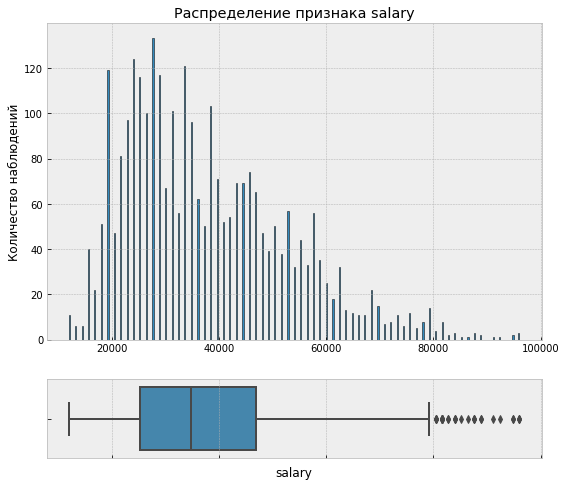

In [81]:
creating_graph(no_quit, 'salary')

* Средняя зарплата уволенных сотрудников (23885) значительно ниже, чем у неуволенных (37702).
* Медиана зарплаты у уволенных сотрудников (22800) также ниже, чем у неуволенных (34800). Это означает, что половина уволенных сотрудников получала зарплату 22800 и ниже, в то время как половина неуволенных сотрудников получала 34800 и выше.

Сотрудники, неудовлетворенные уровнем своей зарплаты, могут принимать решение об увольнении в поисках более высокооплачиваемой работы.

Неуволенные сотрудники, как правило, имеют больший стаж работы и опыт, что может объяснять их более высокую зарплату.

Переходя ко второй цели данного пункта – проверке влияния уровня удовлетворенности работой на вероятность увольнения –  необходимо объединить два датафрейма: y_test_1 и y_test_2.

In [82]:
print(f'Размер y_test_2: {y_test_2.shape}')
target_dependency = y_test_2.merge(y_test_1, on='id', how='left')
print(f'Размер target_dependency: {target_dependency.shape}')

Размер y_test_2: (2000, 2)
Размер target_dependency: (2000, 3)


In [83]:
target_dependency.head()

,id,quit,job_satisfaction_rate
0,999029,yes,0.35
1,372846,no,0.21
2,726767,no,0.73
3,490105,no,0.62
4,416898,yes,0.57


Разделим на две группы: уволенных и неуволенных сотрудников. 

In [84]:
target_dependency_no_quit = target_dependency[target_dependency['quit'] == 'no']
target_dependency_quit = target_dependency[target_dependency['quit'] == 'yes']

In [85]:
print(f'Размер выборки неуволенных сотрудников: {target_dependency_no_quit.shape}')
print(f'Размер выборки уволенных сотрудников: {target_dependency_quit.shape}')

Размер выборки неуволенных сотрудников: (1436, 3)
Размер выборки уволенных сотрудников: (564, 3)


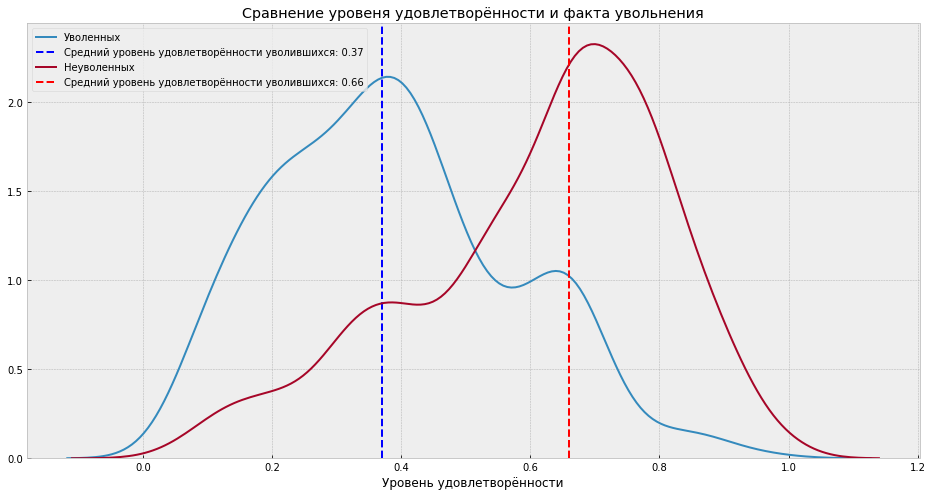

In [86]:
fig, axes = plt.subplots(figsize=(16, 8))

# График уволенных
sns.kdeplot(
    data=target_dependency_quit['job_satisfaction_rate'],
    label='Уволенных',
    ax=axes
)

# Медиана для графика уволенных
median_quit = target_dependency_quit['job_satisfaction_rate'].median()
axes.axvline(
    median_quit,
    color='blue',
    linestyle='--',
    label=f'Средний уровень удовлетворённости уволившихся: {median_quit:.2f}'
)
# График неуволенных
sns.kdeplot(
    data=target_dependency_no_quit['job_satisfaction_rate'],
    label='Неуволенных',
    ax=axes
)

# Медиана для графика неуволенных
median_no_quit = target_dependency_no_quit['job_satisfaction_rate'].median()
axes.axvline(
    median_no_quit,
    color='red',
    linestyle='--',
    label=f'Средний уровень удовлетворённости уволившихся: {median_no_quit:.2f}'
)

axes.set_title('Сравнение уровеня удовлетворённости и факта увольнения')
plt.xlabel('Уровень удовлетворённости')
plt.ylabel('')
plt.legend(loc='upper left')
plt.show()

Анализ данных подтверждает, что уровень удовлетворенности работой является значимым фактором, влияющим на решение сотрудника об увольнении. У уволившихся сотрудников уровень удовлетворенности работой в среднем ниже, чем у оставшихся: 0.39 против 0.61.

Проанализируем матрицу корреляций.

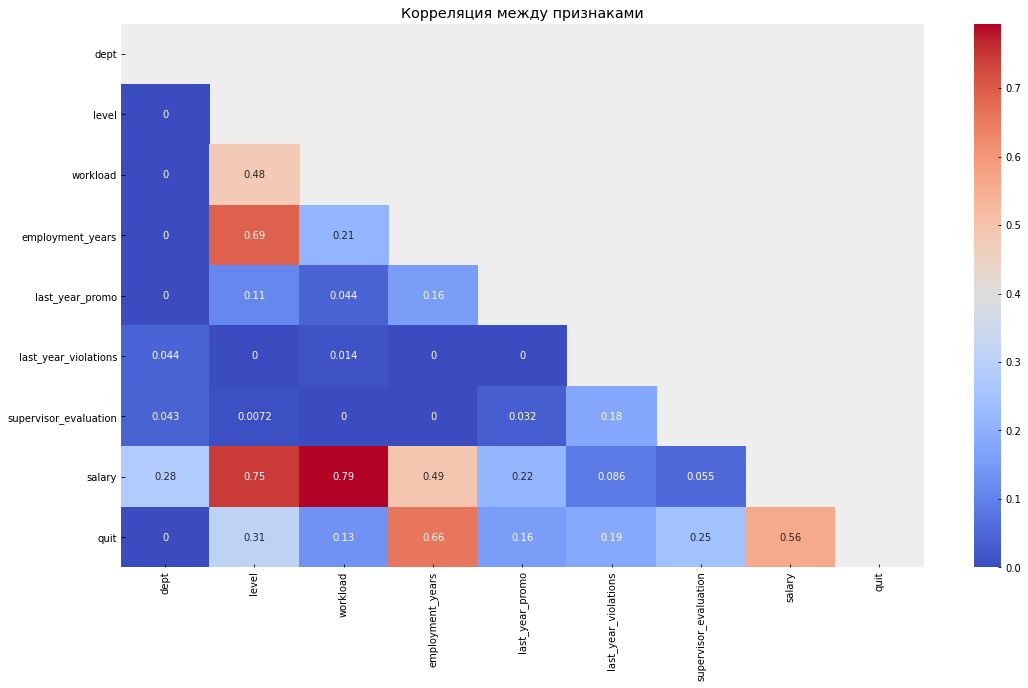

In [87]:
nam_col_names = df_quit.drop('id', axis=1).select_dtypes(include='number').columns.tolist()

phik_matrix = df_quit.drop('id', axis=1).phik_matrix(interval_cols=nam_col_names)

mask = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(18, 10))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', mask=mask)
plt.title('Корреляция между признаками')
plt.show()

Наиболее сильная корреляция с вероятностью увольнения сотрудника ("quit") наблюдается у переменных "длительность работы в компании" ("employment_years", 0.66) и "ежемесячная зарплата" ("salary", 0.56).  При этом отдел, в котором работает сотрудник ("dept"), практически не связан с вероятностью увольнения (корреляция близка к нулю).

Мультиколлинеарность  и утечка целевого признака в  данных  отсутствует.

<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> можно составить следующий обобщенный портрет уволившегося сотрудника:

1. Должность и опыт:

* Junior-специалист с небольшим опытом работы (в среднем 1.84 года,  часто всего 1 год).
* Возможно, работает в отделе продаж (sales).  Хотя отдел продаж не выделяется с наибольшим количеством увольнений относительно общего числа сотрудников,  он имеет  высокую текучесть кадров.

2. Уровень загруженности:

* Имеет низкий или средний уровень загруженности. Возможно,  испытывает недостаток интересных задач,  чувствует себя недооцененным  или  сталкивается с  выгоранием.

3. Карьерный рост и признание:

* Не получал повышения за последний год.  Вероятно,  не  чувствовал  признания  своих заслуг  и  не видел  перспектив  карьерного  роста  в  компании.

4. Оценка качества работы:

* Получил  среднюю  или  низкую  оценку  качества  работы  от  руководителя (медиана  3).  Это  могло  демотивировать  сотрудника  и  подтолкнуть  к  решению  об  увольнении.

5. Уровень заработной платы:

* Имеет  относительно  невысокий  уровень  заработной  платы (медиана  22800).  Возможно,  был  неудовлетворен  уровнем  своей  зарплаты  и  искал  более  высокооплачиваемую  работу.

6. Нарушения трудового договора:

* С  некоторой  вероятностью  нарушал  трудовой  договор  за  последний  год.  Это  могло  стать  причиной  увольнения.

Проведенный анализ данных подтверждает, что  уровень удовлетворенности работой является важным фактором, влияющим на решение сотрудника об увольнении.  У уволившихся сотрудников уровень удовлетворенности  значительно ниже, чем у оставшихся (0.39 против 0.61). 

Наиболее сильными предикторами увольнения являются длительность работы в компании и ежемесячная зарплата.  Вероятность увольнения  возрастает с уменьшением стажа  и  уровня  зарплаты.  При этом  принадлежность к определенному отделу  практически не связана с  решением  об увольнении.

Важно отметить, что  в данных  отсутствуют  мультиколлинеарность  и  утечка  целевого  признака, что  повышает  надежность  полученных  результатов.
</div>

### Добавление нового входного признака

Добавим job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [88]:
print(f'Размер df_quit до добавления признака: {df_quit.shape}')
df_quit['job_satisfaction_rate'] = best_model.predict(df_quit.drop('quit', axis=1))
print(f'Размер df_quit после добавления признака: {df_quit.shape}')

Размер df_quit до добавления признака: (4000, 10)
Размер df_quit после добавления признака: (4000, 11)


In [89]:
df_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.606667
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.821905
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.326667
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.337500
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.812500


Включим признак job_satisfaction_rate в тестовую выборку.

In [90]:
print(f'Размер X_test_2 до добавления признака: {X_test_2.shape}')
X_test_2['job_satisfaction_rate'] = best_model.predict(X_test_2)
print(f'Размер X_test_2 после добавления признака: {X_test_2.shape}')

Размер X_test_2 до добавления признака: (2000, 9)
Размер X_test_2 после добавления признака: (2000, 10)


In [91]:
X_test_2.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.883333
1,686555,hr,junior,medium,1,no,no,4,30000,0.682222
2,467458,sales,middle,low,5,no,no,4,19200,0.683750
3,418655,sales,middle,low,6,no,no,4,19200,0.713333
4,789145,hr,middle,medium,5,no,no,5,40800,0.812500


<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> в данном разделе мы обогатили датасет, предназначенный для решения задачи классификации увольнения сотрудников (df_quit), добавив  признак  уровня  удовлетворенности  работой  (job_satisfaction_rate).  Теперь данные готовы к этапу предварительной обработки в пайплайне и последующего построения моделей.
</div>

### Подготовка данных

Вместо числовых индексов в df_quit, X_test_2 и y_test_2 будем использовать идентификаторы (ID) сотрудников. Затем объединим X_test_2 и y_test_2 в один датафрейм, чтобы обеспечить соответствие индексов. После этого разделим полученные таблицы на обучающую и тестовую выборки. 

In [92]:
df_quit = df_quit.set_index('id')
X_test_2  = X_test_2.set_index('id')
y_test_2 = y_test_2.set_index('id')

In [93]:
print(f'Размер X_test_2: {X_test_2.shape}')
full_test_2 = X_test_2.merge(y_test_2, right_index=True, left_index=True)
print(f'Размер full_test_2: {full_test_2.shape}')

Размер X_test_2: (2000, 9)
Размер full_test_2: (2000, 10)


In [94]:
X_train_2 = df_quit.drop('quit', axis=1)
y_train_2 = df_quit['quit']

In [95]:
X_test_2 = full_test_2.drop('quit', axis=1)
y_test_2 = full_test_2['quit']

In [96]:
print(f'Размер X_train_2: {X_train_2.shape}')
print(f'Размер y_train_2: {y_train_2.shape}')
print()
print(f'Размер X_test_2: {X_test_2.shape}')
print(f'Размер y_test_2: {y_test_2.shape}')

Размер X_train_2: (4000, 9)
Размер y_train_2: (4000,)

Размер X_test_2: (2000, 9)
Размер y_test_2: (2000,)


Поскольку  подготовка данных для данной задачи  в основном аналогична  подготовке  в  задаче 1,  мы  будем  использовать  ранее  построенный  пайплайн.  Единственное  изменение  заключается  в  добавлении  признака  "job_satisfaction_rate"  к  списку  числовых  признаков  ("num_columns"). 

In [97]:
num_columns.append('job_satisfaction_rate')

In [98]:
print(ohe_columns)
print(ord_columns)
print(num_columns)

['dept', 'last_year_promo', 'last_year_violations']
['level', 'workload']
['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


Заменим модель LinearRegression в пайплайне на LogisticRegression, подходящую для задачи классификации. 

В связи с  наличием  дисбаланса  классов  в  данных,  для  его  устранения  будет  применен  алгоритм  SMOTE  (Synthetic Minority Over-sampling Technique).

Важно  отметить,  что  при  использовании  SMOTE  в  пайплайне  необходимо  использовать  imblearn.pipeline.Pipeline  вместо  sklearn.pipeline.Pipeline.  Это  обусловлено  тем,  что  imblearn.pipeline.Pipeline  обеспечивает  корректную  обработку  SMOTE  и  других  методов  из  библиотеки  imblearn  в  рамках  кросс-валидации,  выполняемой  с  помощью  GridSearchCV  и  RandomizedSearchCV.  

In [99]:
sampler = SMOTE(random_state=42, k_neighbors=5)

In [100]:
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('smote', sampler),
    ('models', LogisticRegression())
])

<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> в данном разделе была проведена подготовка данных для решения задачи классификации увольнения сотрудников.

Ключевые шаги:

1. Идентификация сотрудников:  Вместо числовых индексов в датафреймах df_quit, X_test_2 и y_test_2 были использованы идентификаторы (ID) сотрудников для обеспечения корректного объединения данных и последующего анализа.
2. Объединение и разделение данных: X_test_2 и y_test_2 были объединены в единый датафрейм, после чего данные были разделены на обучающую и тестовую выборки.
3. Адаптация пайплайна:  В связи с  аналогичностью  подхода  к  подготовке  данных  с  задачей 1,  был  использован  ранее  построенный  пайплайн.
4. Добавление нового признака:  К списку числовых признаков ("num_columns") был добавлен признак "job_satisfaction_rate",  учитывающий  уровень  удовлетворенности  работой  сотрудников.
5. Замена модели:  Модель LinearRegression в пайплайне была заменена на LogisticRegression,  более  подходящую  для  решения  задачи  классификации.
6. Добавление алгоритма  SMOTE в связи с  наличием  дисбаланса  классов.
</div>

### Обучение моделей

Цель данного раздела — разработать и оценить несколько моделей машинного обучения для прогнозирования увольнения сотрудников (целевой признак "quit") на основе имеющихся данных, включая новый признак "job_satisfaction_rate". Также нужно добиться значения ROC-AUC ≥ 0.91 на тестовой выборке для лучшей модели.

In [101]:
param_grid_2 = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__max_features': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__C': range(1, 10),
        'models__kernel': ['rbf', 'linear', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
] 

In [102]:
best_model = 0
best_train_score = 0
best_test_score = 0

for grid in param_grid_2:
    
    print(grid['models'][0])
    
    search_class = RandomizedSearchCV(
        pipe_final_2, 
        grid, 
        scoring='roc_auc', 
        random_state=RANDOM_STATE,
        cv=10,
        n_jobs=-1,
        n_iter=10
    )
    search_class .fit(X_train_2, y_train_2)
    
    model = search_class.best_estimator_
    train_score = search_class.best_score_
    test_score = roc_auc_score(y_test_2, search_class.predict_proba(X_test_2)[:, 1])
    
    if best_test_score == 0:
        best_model = model
        best_train_score = train_score
        best_test_score = test_score
    else:
        if best_test_score <= test_score:
            best_model = model
            best_train_score = train_score
            best_test_score = test_score
        else:
            pass
        
    #print(best_model)
    print(f'Лучшее значение ROC-AUC модели на тренировочной выборке: {train_score}')
    print(f'Лучшее значение ROC-AUC модели на тестовой выборке: {test_score}')
    print('__' * 50)
    
# SVC долго обрабатывается, нужно подождать минут 5

KNeighborsClassifier()
Лучшее значение ROC-AUC модели на тренировочной выборке: 0.9253145838178021
Лучшее значение ROC-AUC модели на тестовой выборке: 0.9152288419368221
____________________________________________________________________________________________________
DecisionTreeClassifier(random_state=42)
Лучшее значение ROC-AUC модели на тренировочной выборке: 0.920778332079603
Лучшее значение ROC-AUC модели на тестовой выборке: 0.9213363559137874
____________________________________________________________________________________________________
SVC(probability=True, random_state=42)
Лучшее значение ROC-AUC модели на тренировочной выборке: 0.9322364914324515
Лучшее значение ROC-AUC модели на тестовой выборке: 0.9244212894367727
____________________________________________________________________________________________________
LogisticRegression(random_state=42)
Лучшее значение ROC-AUC модели на тренировочной выборке: 0.9174004474296285
Лучшее значение ROC-AUC модели на тестовой 

Метрика ROC-AUC моделей без алгоритма SMOTE

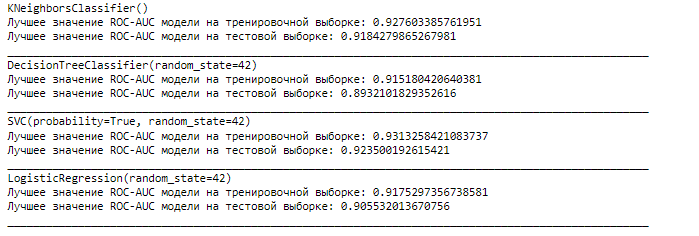

In [103]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_befor...
                                                                                               'medium',
                                                                                               'high']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num', MinMaxScaler(),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary',
                                                   'job_satisfaction_rate'])])),
                ('smote', SMOTE(random_state=42)),
                ('models', SVC(C=4, probability=True, random_state=42))])

Наилучшее качество на тестовой выборке продемонстрировала модель SVC(probability=True, random_state=42) с ROC-AUC, равным 0.9244. SVC  хорошо  работает  с  данными,  имеющими  большое  число  признаков,  благодаря  использованию  ядерных  функций. SVC  с  использованием  нелинейной  ядерной  функции  (RBF, стоит изначально)  может  более  эффективно  обрабатывать  нелинейные  зависимости  и  высокую  размерность  данных.

Важно  отметить,  что  DecisionTreeClassifier  также  показала  хорошее  качество  на  тестовой  выборке  (ROC-AUC = 0.9213). И стоит отметить, что DecisionTreeClassifier обучилась намного быстрее.

In [104]:
y_pred_2 = best_model.predict(X_test_2)

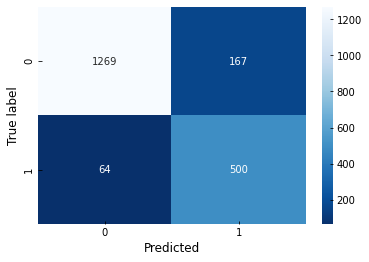

In [105]:
cm = confusion_matrix(y_test_2, y_pred_2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted')
plt.show()

Матрица ошибок без алгоритма SMOTE

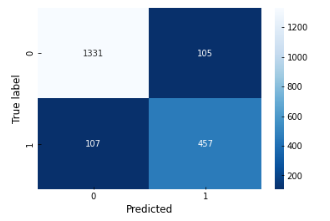

Первоначально обучение моделей проводилось без использования алгоритма SMOTE для балансировки классов. В результате лучшая модель демонстрировала тенденцию к ошибочной классификации объектов минорного класса в пользу мажорного. Анализ матрицы ошибок выявил около 100 ошибок второго рода. После применения SMOTE количество ошибок второго рода снизилось до 64. Однако, стоит отметить, что количество ошибок первого рода при этом увеличилось со 100 до 167.

С точки зрения бизнеса, удержание существующих сотрудников, как правило, выгоднее, чем найм и адаптация новых. Замена уволившихся сотрудников  влечет за собой дополнительные расходы, связанные с поиском, отбором, адаптацией и обучением новых кадров.  Кроме того,  новые  сотрудники  требуют  времени  на  достижение  полной  производительности,  что  также  может  негативно  сказаться  на  эффективности  бизнеса.  

In [106]:
# Извлечение модели из пайплайна
model = best_model.named_steps['models']

X_train_shap_2 = pd.DataFrame(
    pipe_final_2.named_steps['preprocessor'].fit_transform(X_train_2), 
    columns = pipe_final.named_steps['preprocessor'].get_feature_names_out()
)
X_test_shap_2 = pd.DataFrame(
    pipe_final_2.named_steps['preprocessor'].transform(X_test_2), 
    columns = pipe_final.named_steps['preprocessor'].get_feature_names_out()
)

In [107]:
explainer_2 = shap.Explainer(model.predict_proba, X_train_shap_2[:10])
shap_values = explainer_2(X_test_shap_2[:10])

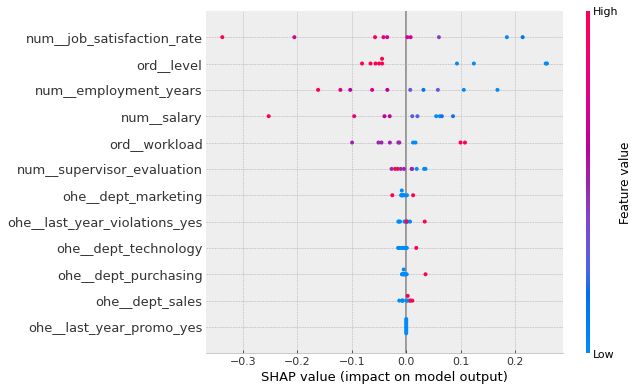

In [108]:
shap.plots.beeswarm(shap_values[:,:,1], max_display = 21) 

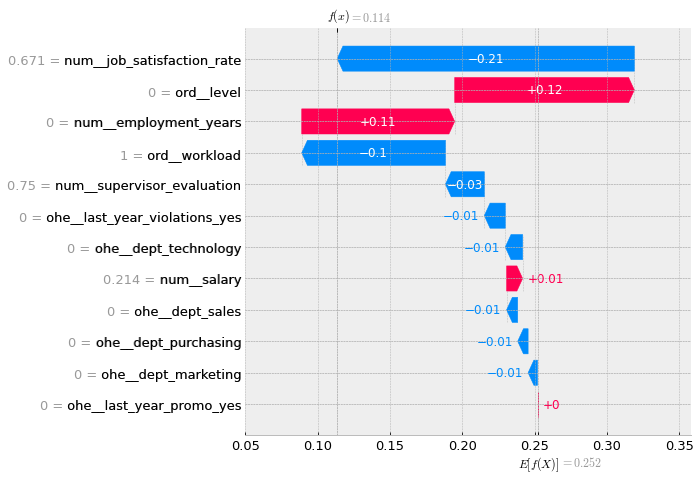

In [109]:
shap.plots.waterfall(shap_values[1,:,1], max_display = 21)

Модель SVC  определила  следующие  признаки  как  наиболее  влияющие  на  прогнозирование  увольнения:

* Уровень удовлетворенности работой (job_satisfaction_rate): Чем выше уровень удовлетворенности, тем меньше вероятность увольнения.
* Уровень занимаемой должности (level): Сотрудники на более низких должностях выше вероятность увольняются.
* Длительность работы в компании (employment_years): Чем меньше стаж работы, тем выше вероятность увольнения.

Наименее важным признаком оказалась информация о повышении за последний год (last_year_promo).

<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> в рамках данного исследования была проведена разработка и оценка нескольких моделей машинного обучения для прогнозирования увольнения сотрудников на основе имеющихся данных, включая новый признак "уровень удовлетворенности работой" (job_satisfaction_rate). Целью исследования было достижение значения метрики ROC-AUC не менее 0.91 на тестовой выборке для лучшей модели.

В исследовании были рассмотрены следующие модели:

* KNeighborsClassifier: ROC-AUC на тестовой выборке - 0.9152
* DecisionTreeClassifier: ROC-AUC на тестовой выборке - 0.9213
* SVC: ROC-AUC на тестовой выборке - 0.9244
* LogisticRegression: ROC-AUC на тестовой выборке - 0.9065


Наилучшие результаты продемонстрировала модель SVC (Support Vector Classifier) с использованием нелинейной ядерной функции (RBF), которая достигла значения ROC-AUC, равного 0.9244 на тестовой выборке, превысив поставленный порог. SVC эффективно справляется с задачами классификации, особенно при наличии большого числа признаков и нелинейных зависимостей в данных.

Стоит отметить, что модель DecisionTreeClassifier также показала высокое качество (ROC-AUC = 0.9213) и значительно более высокую скорость обучения по сравнению с SVC. Модель KNeighborsClassifier также превысила заданный порог по метрике ROC-AUC, но показала результат хуже, чем DecisionTreeClassifier и SVC. Модель LogisticRegression не смогла достичь требуемого уровня качества.
    
Анализ матрицы ошибок показал, что изначальное обучение моделей без использования алгоритма SMOTE для балансировки классов приводило к большому числу ошибок второго рода (около 100). Применение SMOTE позволило снизить это значение до 64, однако при этом увеличилось число ошибок первого рода (со 100 до 167). Этот факт указывает на необходимость тщательного подбора методов балансировки классов и оценки их влияния на различные типы ошибок.

Анализ важности признаков для модели SVC показал, что наиболее значимыми факторами, влияющими на вероятность увольнения, являются: уровень удовлетворенности работой, уровень занимаемой должности и длительность работы в компании. Наименее важным признаком оказалась информация о повышении за последний год.

В целом, исследование продемонстрировало эффективность использования модели SVC для прогнозирования увольнения сотрудников. Полученные результаты могут быть использованы для разработки системы раннего предупреждения риска увольнения и принятия мер по его снижению, таких как повышение уровня удовлетворенности работой и проведение мероприятий по удержанию ценных сотрудников.
</div>

### Выводы по задаче

<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> был проведен предварительный анализ данных для задачи прогнозирования увольнения сотрудников.

Ключевые результаты анализа:

* Структура данных:  Датафрейм df_quit (4000 строк и 10 столбцов)  содержит  информацию  о  сотрудниках  и  факте  их  увольнения  (quit).  Структура  данных  аналогична  датафрейму  из  предыдущей  задачи,  но  с  другим  целевым  признаком  и  отсутствием  пропусков  и  аномалий.
* Тестовая выборка:  Датафреймы  X_test_2  и  y_test_2  содержат  информацию  о  2000  сотрудниках  для  тестирования  модели. 
* Подготовка тестовой выборки:  Для  X_test_2  будет  выполнена  обработка  пропусков  в  рамках  пайплайна.

Анализ уникальных значений:

* Выявлена опечатка: В  df_quit  обнаружена  опечатка  в  значении  признака  level  ("sinior"  вместо  "senior"),  которая  будет  исправлена.
* Данные признаны качественными: В  целом,  данные  признаны  качественными  и  готовыми  для  дальнейшего  анализа.

Обобщенный портрет уволившегося сотрудника:

Анализ данных позволил составить следующий обобщенный портрет уволившегося сотрудника:

* Должность и опыт: Junior-специалист с небольшим опытом работы (в среднем 1.84 года).
* Отдел: Возможно, работает в отделе продаж (sales),  который  характеризуется  высокой  текучестью  кадров.
* Уровень загруженности:  Низкий или средний уровень загруженности.
* Карьерный рост: Не получал повышения за последний год.
* Оценка качества работы:  Средняя или низкая оценка качества работы от руководителя.
* Уровень заработной платы:  Относительно невысокий уровень заработной платы.
* Нарушения трудового договора:  С некоторой вероятностью нарушал трудовой договор за последний год.

Ключевые факторы увольнения:

* Уровень удовлетворенности работой:  У уволившихся сотрудников уровень удовлетворенности значительно ниже.
* Длительность работы в компании и зарплата:  Вероятность увольнения возрастает с наличием небольшого стажа и уровня зарплаты.
* Принадлежность к отделу:  Принадлежность к определенному отделу практически не связана с решением об увольнении.
    
Надежность данных:

* Отсутствие мультиколлинеарности и утечки целевого признака:  Данные не содержат мультиколлинеарности и утечки целевого признака, что повышает надежность результатов анализа.
    
Обогащение данных:

* Добавление признака уровня удовлетворенности:  Датасет  df_quit  был  обогащен  признаком  job_satisfaction_rate,  учитывающим  уровень  удовлетворенности  сотрудников  работой.

Подготовка данных:

* Идентификация сотрудников:  В  датафреймах  df_quit,  X_test_2  и  y_test_2  вместо  числовых  индексов  были  использованы  идентификаторы  (ID)  сотрудников.
* Объединение и разделение данных:  X_test_2  и  y_test_2  были  объединены,  и  данные  были  разделены  на  обучающую  и  тестовую  выборки.
* Адаптация пайплайна:  Был  использован  ранее  построенный  пайплайн  из  задачи  1  с  необходимыми  модификациями.
* Добавление нового признака:  Признак  job_satisfaction_rate  был  добавлен  в  список  числовых  признаков  для  использования  в  моделях.
* Замена модели:  Модель  LinearRegression  в  пайплайне  была  заменена  на  LogisticRegression  для  решения  задачи  классификации.
* Добавление алгоритма SMOTE:  В  связи  с  наличием  дисбаланса  классов  был  добавлен  алгоритм  SMOTE  для  балансировки  данных.

Построение и оценка моделей:

* Рассмотренные модели:  KNeighborsClassifier,  DecisionTreeClassifier,  SVC,  LogisticRegression.
* Наилучшая модель:  SVC  с  нелинейной  ядерной  функцией  (RBF)  показала  наилучший  результат  (ROC-AUC = 0.9244  на  тестовой  выборке),  превысив  поставленный  порог  (ROC-AUC ≥ 0.91).
* Другие модели:  DecisionTreeClassifier  также  продемонстрировала  высокое  качество  (ROC-AUC = 0.9213)  и  быструю  скорость  обучения.  KNeighborsClassifier  превысила  заданный  порог,  но  показала  худший  результат,  чем  DecisionTreeClassifier  и  SVC.  LogisticRegression  не  достигла  требуемого  уровня  качества.

Анализ результатов:

* Влияние SMOTE:  Применение  SMOTE  позволило  снизить  число  ошибок  второго  рода,  но  увеличило  число  ошибок  первого  рода,  что  указывает  на  необходимость  тщательного  подбора  методов  балансировки.
* Важность признаков:  Наиболее  важными  признаками  для  модели  SVC  оказались  уровень  удовлетворенности  работой,  уровень  должности  и  длительность  работы.
</div>

## Общий вывод

<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> 
    
<b>Задача 1 проекта была посвящена разработке модели машинного обучения для прогнозирования уровня удовлетворенности сотрудников работой в компании.</b>

Анализ исходных данных:

* Хорошее качество данных: Исходные данные, представленные в датафреймах df, X_test_1 и y_test_1,  демонстрировали хорошее качество,  содержали  минимальное  количество  пропусков  и  опечаток,  а  также  не  имели  аномалий.
* Незначительные расхождения в тестовой выборке:  В  тестовой  выборке  (X_test_1)  были  обнаружены  небольшие  расхождения  в  количестве  уникальных  значений  в  столбцах dept  и  workload  по  сравнению  с  обучающей  выборкой  (df),  которые  были  устранены  на  этапе  предобработки.
* Ключевые особенности данных:  Анализ  данных  выявил  неравномерное  распределение  сотрудников  по  отделам  и  уровням,  средний  стаж  работы  (3  года),  низкий  процент  повышений,  значительную  долю  нарушений  трудового  договора,  положительные  оценки  руководителей,  значительный  разброс  зарплат  и  средний  уровень  удовлетворенности  работой  (0.53).
* Сильная корреляция:  Была  выявлена  сильная  корреляция  удовлетворенности  с  оценкой  руководителя  и  нарушениями  трудового  договора.

Подготовка данных:

* Преобразование индексов:  Числовые  индексы  были  заменены  на  идентификаторы  сотрудников.
* Объединение и разделение данных:  Тестовые  данные  были  объединены,  и  все  данные  были  разделены  на  обучающую  и  тестовую  выборки.
* Классификация признаков:  Переменные  были  классифицированы  на  категориальные,  ранговые  и  числовые.
* Выбор методов предобработки:  Были  выбраны  соответствующие  методы  предобработки  для  каждого  типа  признаков,  включая  OneHotEncoder,  OrdinalEncoder,  MinMaxScaler,  StandardScaler  и  SimpleImputer.
* Создание пайплайнов:  Были  созданы  пайплайны  для  подготовки  данных  и  объединения  подготовки  данных  с  моделью.

Построение и оценка моделей:

* Рассмотренные модели:  LinearRegression  и  DecisionTreeRegressor.
* Наилучшая модель:  DecisionTreeRegressor  с  подобранными  гиперпараметрами  (max_depth=17  и  min_samples_leaf=3)  показала  наилучший  результат  по  метрике  SMAPE  (значительно  меньше  15  на  тестовой  выборке),  успешно  выполнив  критерий  успеха. 
* Преимущество DecisionTreeRegressor:  DecisionTreeRegressor  превзошла  LinearRegression  благодаря  своей  способности  моделировать  нелинейные  зависимости  и  взаимодействие  признаков.

Анализ результатов:

* Качество модели:  Анализ  остатков  модели  DecisionTreeRegressor  подтвердил  ее  хорошее  качество  и  отсутствие  систематических  ошибок.
* Важность признаков:  Наиболее  важными  признаками  для  прогнозирования  уровня  удовлетворенности  оказались  оценка  руководителя,  стаж  работы  и  зарплата.

Заключение:

В  результате  выполнения  задачи  1  была  разработана  эффективная  модель  машинного  обучения  (DecisionTreeRegressor)  для  прогнозирования  уровня  удовлетворенности  сотрудников  на  основе  имеющихся  данных.  Модель  достигла  заданного  критерия  качества  (SMAPE ≤ 15)  и  выявила  ключевые  факторы,  влияющие  на  удовлетворенность.  
    
<b>Задача 2 проекта была посвящена разработке модели машинного обучения для прогнозирования увольнения сотрудников компании.</b>

Предварительный анализ данных:

* Структура данных:  Датафрейм df_quit (4000 строк и 10 столбцов) содержал информацию о сотрудниках и факте их увольнения (quit).  Данные  были  аналогичны  данным  из  задачи  1,  но  с  другим  целевым  признаком  и  отсутствием  пропусков  и  аномалий.
* Тестовая выборка:  Датафреймы  X_test_2  и  y_test_2  содержали  данные  для  тестирования  модели.
* Анализ уникальных значений:  Была  выявлена  и  исправлена  опечатка  в  значении  признака  level  в  df_quit.  Данные  были  признаны  качественными  и  готовыми  для  дальнейшего  анализа.
* Обобщенный портрет уволившегося сотрудника:  Анализ  данных  позволил  составить  обобщенный  портрет  уволившегося  сотрудника:  junior-специалист  с  небольшим  опытом  работы,  возможно,  из  отдела  продаж,  с  низким  или  средним  уровнем  загруженности,  без  повышения  за  последний  год,  со  средней  или  низкой  оценкой  качества  работы,  относительно  невысокой  зарплатой  и  с  некоторой  вероятностью  нарушения  трудового  договора.
* Ключевые факторы увольнения:  Уровень  удовлетворенности  работой,  длительность  работы  в  компании  и  уровень  зарплаты  оказались  наиболее  значимыми  факторами,  влияющими  на  вероятность  увольнения.  Принадлежность  к  отделу  не  показала  сильной  связи  с  увольнением.
* Надежность данных:  Отсутствие  мультиколлинеарности  и  утечки  целевого  признака  повышает  надежность  результатов  анализа.

Обогащение и подготовка данных:

* Добавление признака уровня удовлетворенности:  Датасет  df_quit  был  обогащен  признаком  job_satisfaction_rate  из  задачи  1.
* Идентификация сотрудников, объединение и разделение данных:  Были  выполнены  стандартные  шаги  подготовки  данных.
* Адаптация пайплайна:  Был  адаптирован  пайплайн  из  задачи  1  для  решения  задачи  классификации.
* Добавление нового признака и замена модели:  Признак  job_satisfaction_rate  был  добавлен  в  пайплайн,  а  модель  LinearRegression  была  заменена  на  LogisticRegression.
* Балансировка классов:  Для  учета  дисбаланса  классов  был  добавлен  алгоритм  SMOTE. 

Построение и оценка моделей:

* Рассмотренные модели:  KNeighborsClassifier,  DecisionTreeClassifier,  SVC,  LogisticRegression.
* Наилучшая модель:  Модель  SVC  с  нелинейной  ядерной  функцией  (RBF)  продемонстрировала  наилучший  результат  (ROC-AUC = 0.9244  на  тестовой  выборке),  превысив  поставленный  порог  (ROC-AUC ≥ 0.91).
* Другие модели:  DecisionTreeClassifier  также  показала  высокое  качество  (ROC-AUC = 0.9213)  и  быструю  скорость  обучения.  KNeighborsClassifier  превысила  порог,  но  уступила  DecisionTreeClassifier  и  SVC.  LogisticRegression  не  достигла  требуемого  уровня  качества.

Анализ результатов:

* Влияние SMOTE: Применение  SMOTE  снизило  число  ошибок  второго  рода,  но  увеличило  число  ошибок  первого  рода,  подчеркивая  важность  тщательного  подбора  методов  балансировки  классов.
* Важность признаков: Наиболее  важными  признаками  для  модели  SVC  оказались:  уровень  удовлетворенности  работой,  уровень  должности  и  длительность  работы  в  компании.

Заключение:

В  результате  выполнения  задачи  2  была  разработана  эффективная  модель  машинного  обучения  (SVC)  для  прогнозирования  вероятности  увольнения  сотрудников.  Модель  достигла  заданного  критерия  качества  (ROC-AUC ≥ 0.91)  и  выявила  ключевые  факторы,  влияющие  на  решение  сотрудников  об  увольнении.
    
<b>Рекомендации бизнесу по сохранению старых сотрудников:</b>

* Инвестируйте в обучение и развитие сотрудников: Предлагайте возможности для повышения квалификации,  освоения  новых  навыков  и  профессионального  роста.  Это  покажет  сотрудникам,  что  компания  заинтересована  в  их  развитии  и  ценит  их  вклад.
* Поощряйте  самообучение:  Предоставляйте  доступ  к  обучающим  материалам,  онлайн-курсам  и  другим  ресурсам  для  самостоятельного  развития  сотрудников.
* Справедливая  система  оплаты  труда:  Убедитесь,  что  зарплаты  сотрудников  конкурентоспособны  на  рынке  труда  и  соответствуют  их  квалификации,  опыту  и  вкладу  в  работу  компании.
* Предоставляйте  социальный  пакет:  Предлагайте  сотрудникам  дополнительные  льготы  и  компенсации,  такие  как  медицинское  страхование,  страхование  жизни,  оплата  мобильной  связи,  питание  в  офисе  и  т.д.   
* Создайте  комфортную  и  безопасную  рабочую  среду:  Обеспечьте  сотрудников  эргономичными  рабочими  местами,  необходимым  оборудованием  и  материалами,  а  также  соблюдайте  требования  охраны  труда  и  техники  безопасности.
* Гибкий  график  работы:  По  возможности,  предоставляйте  сотрудникам  гибкий  график  работы  или  возможность  работать  удаленно.  Это  позволит  им  лучше  совмещать  работу  с  личной  жизнью  и  повысит  их  лояльность  к  компании.
* Регулярная  обратная  связь:  Проводите  регулярные  оценки  работы  сотрудников,  обсуждайте  их  достижения  и  области  для  развития.  Важно,  чтобы  сотрудники  понимали,  как  их  работа  влияет  на  общий  успех  компании  и  какие  перспективы  их  ждут.
* Открытая  и  честная  коммуникация:  Создайте  атмосферу  доверия  и  взаимопонимания  в  коллективе.  Поощряйте  сотрудников  открыто  высказывать  свое  мнение,  задавать  вопросы  и  делиться  идеями.
    
</div>
